<a href="https://colab.research.google.com/github/Franciscamm/DLNN-2023/blob/main/DLNN_%E2%80%93_Emotion_Recognition_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# importing libraries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics

import tensorflow.keras.layers as layers
from tensorflow.keras import Sequential,Input,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import LeakyReLU
import visualkeras

import os
import time
import random 
import zipfile
from shutil import copyfile

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

from sklearn.metrics import confusion_matrix

IMPORT DATA

In [ ]:
# Google drive connection

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Unzip file to virtual machine's session«

# Set connection string
path = "/content/drive/MyDrive/DLNN/"
# Measure time
t0 = time.time()
# Transfer zip dataset to the current virtual machine
copyfile(path + "emotion-model-4-.v2i.folder.zip", 'emotion-model.zip')
# Extract files
zip_file = zipfile.ZipFile('emotion-model.zip')
zip_file.extractall()
zip_file.close()
print("File transfer completed in %0.3f seconds" % (time.time() - t0))
path = "/content/"
# Define the sub-folders
training_folder, testing_folder, validation_folder = "train/", "test/", "valid/"

File transfer completed in 0.952 seconds


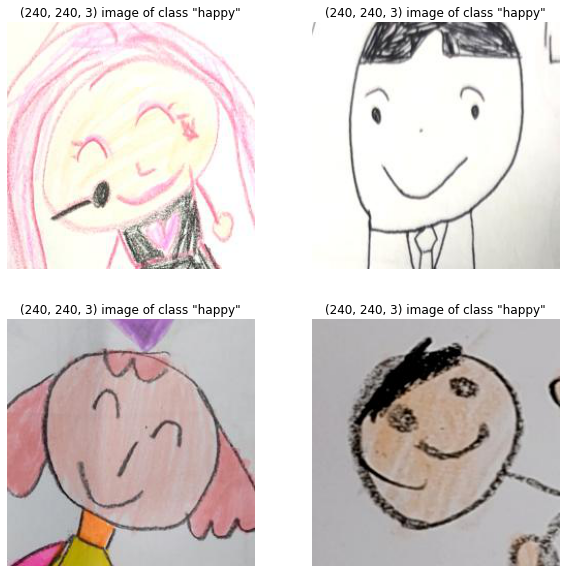

In [ ]:
# take a look into images
# specific class -> happy

def show_sample_images(folder_directory, class_):
    # Build a connection string
    full_path = folder_directory + class_ + "/"
    # Get a set of random images
    images = random.sample(os.listdir(full_path), 4)
    # Plot the images
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(images):
        img = mpimg.imread(full_path + img)
        ax = plt.subplot(2, 2,  i + 1)
        plt.imshow(img)
        plt.title("{} image of class \"{}\"".format(img.shape, class_))
        plt.axis("off")

show_sample_images(path + training_folder, "happy")

In [ ]:
# inspect classes balance

for split in [training_folder, validation_folder]:
    for c in ["happy", "normal", "sad"]:
        n_train_c = len(os.listdir(path + split + f"{c}"))
        print(f"Nº of instances of class {c} in the {split}: {n_train_c}")

for split in [testing_folder]:
    for c in ["happy", "normal", "sad"]:
        n_train_c = len(os.listdir(path + split + f"{c}"))
        print(f"Nº of instances of class {c} in the {split}: {n_train_c}")

Nº of instances of class happy in the train/: 261
Nº of instances of class normal in the train/: 258
Nº of instances of class sad in the train/: 213
Nº of instances of class happy in the valid/: 40
Nº of instances of class normal in the valid/: 34
Nº of instances of class sad in the valid/: 27
Nº of instances of class happy in the test/: 12
Nº of instances of class normal in the test/: 6
Nº of instances of class sad in the test/: 34


In [ ]:
# image_dataset_from_directory params

image_size=(128, 128)
crop_to_aspect_ratio = True
color_mode='rgb'
batch_size=64
label_mode="categorical"
shuffle=True
seed=0

In [ ]:
# Loading data/images

ds_train = image_dataset_from_directory(path + training_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

ds_valid = image_dataset_from_directory(path + validation_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

ds_test = image_dataset_from_directory(path + testing_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)


# Check object properties
print("\nObject's type:\t", type(ds_train))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_train, tf.data.Dataset))
print("Classes:", ds_train.class_names)

Found 732 files belonging to 3 classes.
Found 101 files belonging to 3 classes.
Found 52 files belonging to 3 classes.

Object's type:	 <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['happy', 'normal', 'sad']


In [ ]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()
print(batch_x_train.shape, batch_y_train.shape)
print("\nSample of y_train:", batch_y_train[0:5])
print("Sample average of y_train:", tf.reduce_mean(batch_y_train))

(64, 128, 128, 3) (64, 3)

Sample of y_train: tf.Tensor(
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]], shape=(5, 3), dtype=float32)
Sample average of y_train: tf.Tensor(0.33333334, shape=(), dtype=float32)


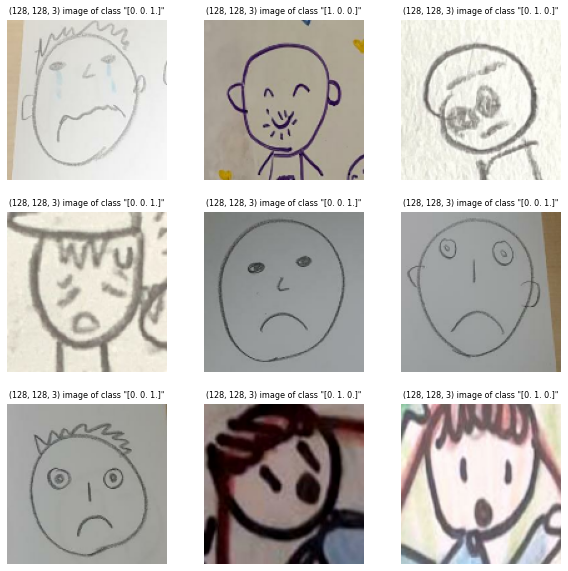

In [ ]:
def show_sample_batch(ds, grid_size=(3, 3)):
    n_images = grid_size[0]*grid_size[1]
    # Get a batch via iteration
    iter_ = iter(ds)
    batch_x, batch_y = iter_.next()
    batch_x, batch_y = batch_x[0:n_images], batch_y[0:n_images]
    # Plot the images
    plt.figure(figsize=(10, 10))
    for i, (img, y) in enumerate(zip(batch_x, batch_y)):
        ax = plt.subplot(grid_size[0], grid_size[1],  i + 1)
        plt.imshow(tf.cast(img, tf.int32))
        plt.title("{} image of class \"{}\"".format(img.shape, y), size=8)
        plt.axis("off")

show_sample_batch(ds_train)


BUILDING MODELS

CNN 1

In [ ]:
input_shape = tuple(batch_x_train.shape)

# Architecture CNN1
# dense layer activation = softmax
# hidden layers activation = relu 

cnn1 = Sequential([# Feature extraction
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn1.build(input_shape)

# Check network
cnn1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (64, 126, 126, 32)        896       
                                                                 
 activation (Activation)     (64, 126, 126, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (64, 63, 63, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (64, 61, 61, 64)          18496     
                                                                 
 activation_1 (Activation)   (64, 61, 61, 64)          0         
                                                                 
 global_max_pooling2d (Globa  (64, 64)                 0         
 lMaxPooling2D)                                         

Epoch 1/15
12/12 [==============================] - 29s 2s/step - loss: 18.4216 - accuracy: 0.3710 - AUROC: 0.5345 - val_loss: 6.0872 - val_accuracy: 0.4455 - val_AUROC: 0.5763
Epoch 2/15
12/12 [==============================] - 15s 1s/step - loss: 4.9050 - accuracy: 0.4637 - AUROC: 0.6185 - val_loss: 4.2334 - val_accuracy: 0.4851 - val_AUROC: 0.6251
Epoch 3/15
12/12 [==============================] - 14s 1s/step - loss: 3.0847 - accuracy: 0.5242 - AUROC: 0.6963 - val_loss: 3.5636 - val_accuracy: 0.5149 - val_AUROC: 0.6448
Epoch 4/15
12/12 [==============================] - 15s 1s/step - loss: 2.2214 - accuracy: 0.5726 - AUROC: 0.7467 - val_loss: 3.2533 - val_accuracy: 0.4752 - val_AUROC: 0.6636
Epoch 5/15
12/12 [==============================] - 15s 1s/step - loss: 1.6374 - accuracy: 0.6358 - AUROC: 0.7920 - val_loss: 2.7201 - val_accuracy: 0.4851 - val_AUROC: 0.6688
Epoch 6/15
12/12 [==============================] - 16s 1s/step - loss: 1.3019 - accuracy: 0.6465 - AUROC: 0.8254 - val

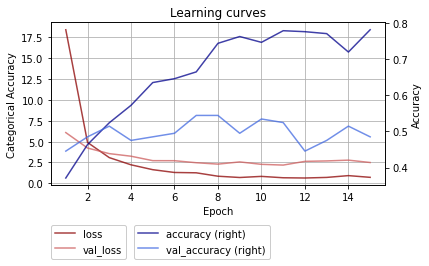

In [ ]:
#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 15
history1 = cnn1.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist1 = pd.DataFrame.from_dict(history1.history)
df_hist1["Epoch"] = np.arange(1, len(df_hist1) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist1.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

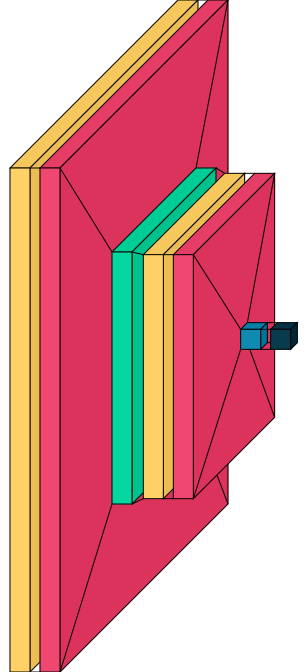

In [ ]:
#visualize the model
visualkeras.layered_view(cnn1)

CNN 2

In [ ]:
input_shape = tuple(batch_x_train.shape)

# Architecture CNN2
# dense layer activation = softmax
# hidden layers activation = softmax 

cnn2 = Sequential([# Feature extraction
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn2.build(input_shape)

# Check network
cnn2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (64, 126, 126, 32)        896       
                                                                 
 activation_4 (Activation)   (64, 126, 126, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (64, 63, 63, 32)         0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (64, 61, 61, 64)          18496     
                                                                 
 activation_5 (Activation)   (64, 61, 61, 64)          0         
                                                                 
 global_max_pooling2d_2 (Glo  (64, 64)                 0         
 balMaxPooling2D)                                     

Epoch 1/15
12/12 [==============================] - 18s 1s/step - loss: 1.0998 - accuracy: 0.3199 - AUROC: 0.4874 - val_loss: 1.0960 - val_accuracy: 0.3960 - val_AUROC: 0.5277
Epoch 2/15
12/12 [==============================] - 13s 990ms/step - loss: 1.0955 - accuracy: 0.3669 - AUROC: 0.5545 - val_loss: 1.0918 - val_accuracy: 0.3960 - val_AUROC: 0.5871
Epoch 3/15
12/12 [==============================] - 12s 998ms/step - loss: 1.0922 - accuracy: 0.3669 - AUROC: 0.5631 - val_loss: 1.0877 - val_accuracy: 0.3960 - val_AUROC: 0.6026
Epoch 4/15
12/12 [==============================] - 12s 1s/step - loss: 1.0883 - accuracy: 0.3669 - AUROC: 0.5873 - val_loss: 1.0842 - val_accuracy: 0.3960 - val_AUROC: 0.6090
Epoch 5/15
12/12 [==============================] - 12s 990ms/step - loss: 1.0848 - accuracy: 0.3669 - AUROC: 0.5895 - val_loss: 1.0801 - val_accuracy: 0.3960 - val_AUROC: 0.6036
Epoch 6/15
12/12 [==============================] - 12s 1s/step - loss: 1.0813 - accuracy: 0.3669 - AUROC: 0.59

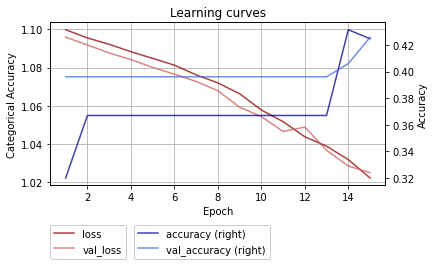

In [ ]:
#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn2.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 15
history2 = cnn2.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist2 = pd.DataFrame.from_dict(history2.history)
df_hist2["Epoch"] = np.arange(1, len(df_hist2) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist2.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

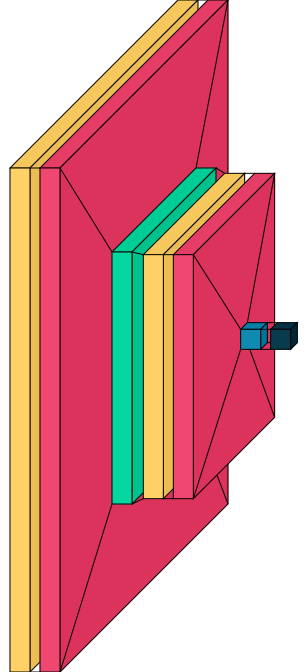

In [ ]:
#visualize the model
visualkeras.layered_view(cnn2)

CNN 1 || Experiments with other optimizers

Epoch 1/15
12/12 [==============================] - 15s 1s/step - loss: 6.0694 - accuracy: 0.5726 - AUROC: 0.7013 - val_loss: 3.1818 - val_accuracy: 0.4455 - val_AUROC: 0.6409
Epoch 2/15
12/12 [==============================] - 15s 1s/step - loss: 1.0910 - accuracy: 0.7231 - AUROC: 0.8769 - val_loss: 4.6623 - val_accuracy: 0.4257 - val_AUROC: 0.5878
Epoch 3/15
12/12 [==============================] - 15s 1s/step - loss: 0.6162 - accuracy: 0.8253 - AUROC: 0.9371 - val_loss: 2.2019 - val_accuracy: 0.5446 - val_AUROC: 0.7057
Epoch 4/15
12/12 [==============================] - 15s 1s/step - loss: 0.4223 - accuracy: 0.8616 - AUROC: 0.9589 - val_loss: 2.1806 - val_accuracy: 0.5644 - val_AUROC: 0.7093
Epoch 5/15
12/12 [==============================] - 15s 1s/step - loss: 0.3842 - accuracy: 0.8817 - AUROC: 0.9640 - val_loss: 2.1094 - val_accuracy: 0.5446 - val_AUROC: 0.7165
Epoch 6/15
12/12 [==============================] - 15s 1s/step - loss: 0.3490 - accuracy: 0.8790 - AUROC: 0.9689 - val_

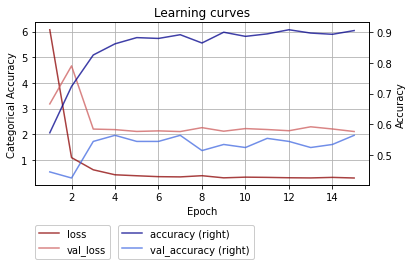

In [ ]:
#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

# optimizers = Adagrad

cnn1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adagrad(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 15
history11 = cnn1.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist11 = pd.DataFrame.from_dict(history11.history)
df_hist11["Epoch"] = np.arange(1, len(df_hist11) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist11.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Epoch 1/15
12/12 [==============================] - 16s 1s/step - loss: 28.1192 - accuracy: 0.4167 - AUROC: 0.5526 - val_loss: 10.3340 - val_accuracy: 0.4257 - val_AUROC: 0.5382
Epoch 2/15
12/12 [==============================] - 14s 1s/step - loss: 8.4466 - accuracy: 0.4583 - AUROC: 0.6089 - val_loss: 10.2262 - val_accuracy: 0.3960 - val_AUROC: 0.5515
Epoch 3/15
12/12 [==============================] - 14s 1s/step - loss: 6.4186 - accuracy: 0.5081 - AUROC: 0.6431 - val_loss: 9.2545 - val_accuracy: 0.4554 - val_AUROC: 0.6246
Epoch 4/15
12/12 [==============================] - 14s 1s/step - loss: 5.2450 - accuracy: 0.5269 - AUROC: 0.6845 - val_loss: 10.0054 - val_accuracy: 0.3069 - val_AUROC: 0.5047
Epoch 5/15
12/12 [==============================] - 14s 1s/step - loss: 4.1773 - accuracy: 0.5726 - AUROC: 0.7269 - val_loss: 3.3615 - val_accuracy: 0.5743 - val_AUROC: 0.7171
Epoch 6/15
12/12 [==============================] - 14s 1s/step - loss: 4.7243 - accuracy: 0.5161 - AUROC: 0.6687 - 

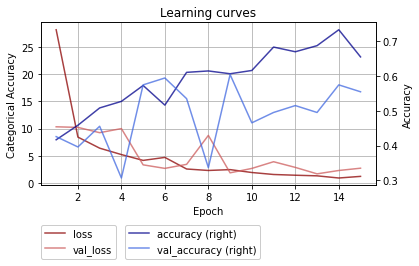

In [ ]:
#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

# optimizers = RMSProp

cnn1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 15
history12 = cnn1.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist12 = pd.DataFrame.from_dict(history12.history)
df_hist12["Epoch"] = np.arange(1, len(df_hist12) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist12.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Epoch 1/15
12/12 [==============================] - 15s 1s/step - loss: 5.9259 - accuracy: 0.3669 - AUROC: 0.5277 - val_loss: 1.1203 - val_accuracy: 0.2673 - val_AUROC: 0.4291
Epoch 2/15
12/12 [==============================] - 14s 1s/step - loss: 1.1176 - accuracy: 0.3105 - AUROC: 0.4603 - val_loss: 1.1043 - val_accuracy: 0.2673 - val_AUROC: 0.4403
Epoch 3/15
12/12 [==============================] - 14s 1s/step - loss: 1.1035 - accuracy: 0.2997 - AUROC: 0.4645 - val_loss: 1.1032 - val_accuracy: 0.2673 - val_AUROC: 0.4192
Epoch 4/15
12/12 [==============================] - 14s 1s/step - loss: 1.0998 - accuracy: 0.3051 - AUROC: 0.4723 - val_loss: 1.1018 - val_accuracy: 0.3168 - val_AUROC: 0.4327
Epoch 5/15
12/12 [==============================] - 14s 1s/step - loss: 1.0965 - accuracy: 0.3347 - AUROC: 0.4904 - val_loss: 1.1002 - val_accuracy: 0.3069 - val_AUROC: 0.5084
Epoch 6/15
12/12 [==============================] - 14s 1s/step - loss: 1.0951 - accuracy: 0.3360 - AUROC: 0.5160 - val_

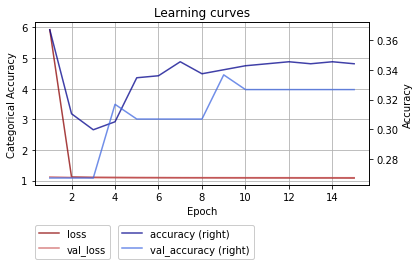

In [ ]:
# higher learning_rate
learning_rate = 0.01

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

# optimizers = SGD

cnn1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.SGD(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training 
epochs = 15
history13 = cnn1.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist13 = pd.DataFrame.from_dict(history13.history)
df_hist13["Epoch"] = np.arange(1, len(df_hist13) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist13.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

the increase of learning rate return worst results

CNN 3 | Introducing batch normalization

In [ ]:
input_shape = tuple(batch_x_train.shape)

# Architecture CNN3
# dense layer activation = softmax
# hidden layers activation = relu
# introducing a batch normalization layer (rescaling data)

cnn3 = Sequential([layers.BatchNormalization(),
                   # Feature extraction
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn3.build(input_shape)

# Check network
cnn3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (64, 128, 128, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d_11 (Conv2D)          (64, 126, 126, 32)        896       
                                                                 
 activation_6 (Activation)   (64, 126, 126, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (64, 63, 63, 32)         0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (64, 61, 61, 64)          18496     
                                                                 
 activation_7 (Activation)   (64, 61, 61, 64)         

Epoch 1/15
12/12 [==============================] - 13s 1s/step - loss: 1.0781 - accuracy: 0.3602 - AUROC: 0.5845 - val_loss: 2.3419 - val_accuracy: 0.2673 - val_AUROC: 0.4696
Epoch 2/15
12/12 [==============================] - 12s 991ms/step - loss: 0.9804 - accuracy: 0.5215 - AUROC: 0.7301 - val_loss: 1.3401 - val_accuracy: 0.3069 - val_AUROC: 0.5459
Epoch 3/15
12/12 [==============================] - 12s 983ms/step - loss: 0.9481 - accuracy: 0.5108 - AUROC: 0.7312 - val_loss: 1.1932 - val_accuracy: 0.4950 - val_AUROC: 0.6223
Epoch 4/15
12/12 [==============================] - 12s 976ms/step - loss: 0.8955 - accuracy: 0.6022 - AUROC: 0.7821 - val_loss: 1.1654 - val_accuracy: 0.4455 - val_AUROC: 0.6394
Epoch 5/15
12/12 [==============================] - 12s 984ms/step - loss: 0.8887 - accuracy: 0.5874 - AUROC: 0.7744 - val_loss: 1.1895 - val_accuracy: 0.3960 - val_AUROC: 0.6335
Epoch 6/15
12/12 [==============================] - 12s 983ms/step - loss: 0.8406 - accuracy: 0.6626 - AUROC

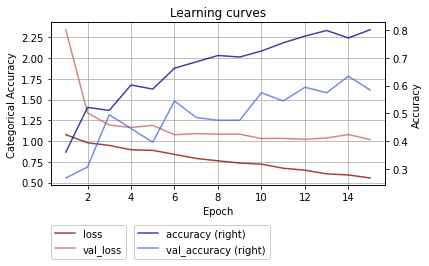

In [ ]:
#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn3.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 15
history3 = cnn3.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist3 = pd.DataFrame.from_dict(history3.history)
df_hist3["Epoch"] = np.arange(1, len(df_hist3) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist3.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

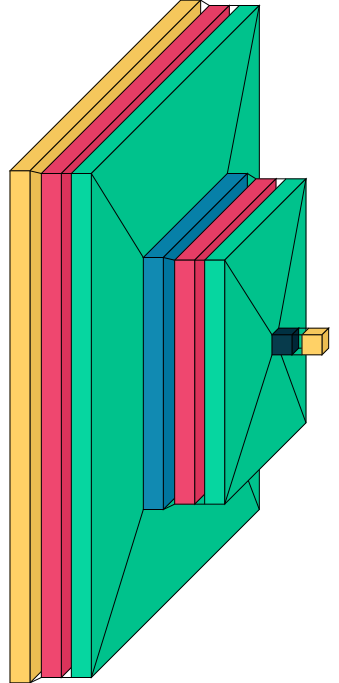

In [ ]:
#visualize the model
visualkeras.layered_view(cnn3)

Epoch 1/150
12/12 [==============================] - 18s 1s/step - loss: 0.5082 - accuracy: 0.8441 - AUROC: 0.9563 - val_loss: 1.0285 - val_accuracy: 0.5644 - val_AUROC: 0.7415
Epoch 2/150
12/12 [==============================] - 17s 1s/step - loss: 0.4839 - accuracy: 0.8508 - AUROC: 0.9611 - val_loss: 1.0456 - val_accuracy: 0.6238 - val_AUROC: 0.7508
Epoch 3/150
12/12 [==============================] - 17s 1s/step - loss: 0.4695 - accuracy: 0.8548 - AUROC: 0.9595 - val_loss: 1.0411 - val_accuracy: 0.6040 - val_AUROC: 0.7570
Epoch 4/150
12/12 [==============================] - 18s 1s/step - loss: 0.4361 - accuracy: 0.8710 - AUROC: 0.9687 - val_loss: 1.0208 - val_accuracy: 0.5446 - val_AUROC: 0.7522
Epoch 5/150
12/12 [==============================] - 17s 1s/step - loss: 0.4031 - accuracy: 0.9073 - AUROC: 0.9786 - val_loss: 1.0187 - val_accuracy: 0.5347 - val_AUROC: 0.7483
Epoch 6/150
12/12 [==============================] - 17s 1s/step - loss: 0.3778 - accuracy: 0.9153 - AUROC: 0.9821 

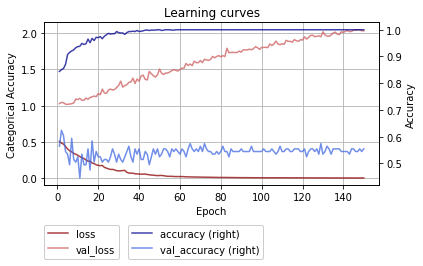

In [ ]:
#experiementing with more than 15 epochs

#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn3.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training 
epochs = 150
history31 = cnn3.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist31 = pd.DataFrame.from_dict(history31.history)
df_hist31["Epoch"] = np.arange(1, len(df_hist31) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist31.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Epoch 1/15
12/12 [==============================] - 18s 1s/step - loss: 0.0018 - accuracy: 1.0000 - AUROC: 1.0000 - val_loss: 2.0401 - val_accuracy: 0.5545 - val_AUROC: 0.7584
Epoch 2/15
12/12 [==============================] - 17s 1s/step - loss: 0.0017 - accuracy: 1.0000 - AUROC: 1.0000 - val_loss: 2.0400 - val_accuracy: 0.5545 - val_AUROC: 0.7584
Epoch 3/15
12/12 [==============================] - 17s 1s/step - loss: 0.0020 - accuracy: 1.0000 - AUROC: 1.0000 - val_loss: 2.0432 - val_accuracy: 0.5545 - val_AUROC: 0.7581
Epoch 4/15
12/12 [==============================] - 17s 1s/step - loss: 0.0020 - accuracy: 1.0000 - AUROC: 1.0000 - val_loss: 2.0412 - val_accuracy: 0.5545 - val_AUROC: 0.7592
Epoch 5/15
12/12 [==============================] - 17s 1s/step - loss: 0.0017 - accuracy: 1.0000 - AUROC: 1.0000 - val_loss: 2.0435 - val_accuracy: 0.5545 - val_AUROC: 0.7584
Epoch 6/15
12/12 [==============================] - 17s 1s/step - loss: 0.0016 - accuracy: 1.0000 - AUROC: 1.0000 - val_

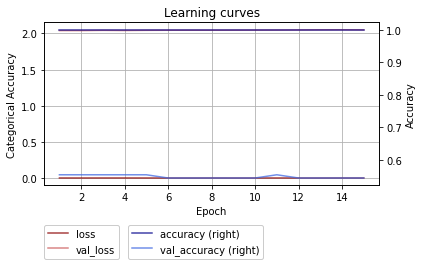

In [ ]:
# Adagrad W/ BATCH NORMALIZATION

#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn3.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adagrad(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 15
history31 = cnn3.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist31 = pd.DataFrame.from_dict(history31.history)
df_hist31["Epoch"] = np.arange(1, len(df_hist31) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist31.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [ ]:
# Adagrad W/ BATCH NORMALIZATION 300 epochs

#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn3.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adagrad(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 150
history32 = cnn3.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist32 = pd.DataFrame.from_dict(history32.history)
df_hist32["Epoch"] = np.arange(1, len(df_hist32) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist32.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Epoch 1/300
12/12 [==============================] - 18s 1s/step - loss: 0.0016 - accuracy: 1.0000 - AUROC: 1.0000 - val_loss: 2.0501 - val_accuracy: 0.5545 - val_AUROC: 0.7586
Epoch 2/300
12/12 [==============================] - 17s 1s/step - loss: 0.0019 - accuracy: 1.0000 - AUROC: 1.0000 - val_loss: 2.0491 - val_accuracy: 0.5545 - val_AUROC: 0.7589
Epoch 3/300
12/12 [==============================] - 17s 1s/step - loss: 0.0019 - accuracy: 1.0000 - AUROC: 1.0000 - val_loss: 2.0514 - val_accuracy: 0.5545 - val_AUROC: 0.7586
Epoch 4/300
12/12 [==============================] - 17s 1s/step - loss: 0.0015 - accuracy: 1.0000 - AUROC: 1.0000 - val_loss: 2.0511 - val_accuracy: 0.5446 - val_AUROC: 0.7586
Epoch 5/300
12/12 [==============================] - 19s 2s/step - loss: 0.0018 - accuracy: 1.0000 - AUROC: 1.0000 - val_loss: 2.0512 - val_accuracy: 0.5545 - val_AUROC: 0.7582
Epoch 6/300
12/12 [==============================] - 17s 1s/step - loss: 0.0016 - accuracy: 1.0000 - AUROC: 1.0000 

KeyboardInterrupt: ignored

CNN 4 | USING DATA AUGMENTATION

"becomes particularly relevant when the dataset is small and underrepresentative of reality. By using data augmentation, the model gets exposed to the different variations in the training data, and it is expected to generalize better"

In [ ]:
augmentation = Sequential([layers.RandomFlip(seed=seed), 
                           layers.RandomRotation(0.1, seed=seed), 
                           layers.RandomZoom(0.1, seed=seed),
                           layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))], 
                           name="augmentation")

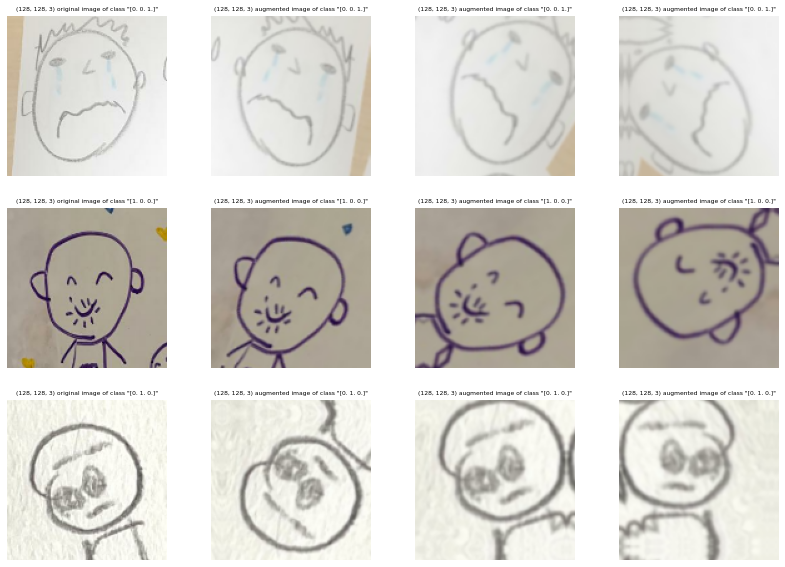

In [ ]:
# Visualizing augmented data

def show_sample_batch(ds, augmentation, grid_size=(3, 4), figsize=(14, 10)):
    n_images = grid_size[0]
    # Get a batch via iteration
    iter_ = iter(ds)
    batch_x, batch_y = iter_.next()
    batch_x, batch_y = batch_x[0:n_images], batch_y[0:n_images]
    # Plot the images
    plt.figure(figsize=(14, 10))
    count = 0
    for i, (img, y) in enumerate(zip(batch_x, batch_y)):
        img_ = tf.cast(img, tf.int32)
        for j in range(grid_size[1]):
            # Prepare the image
            if j>0:
                img_ = tf.cast(augmentation(img_, training=True), tf.int32)
            ax = plt.subplot(grid_size[0], grid_size[1],  count + 1)        
            plt.imshow(img_)
            plt.title("{} {} image of class \"{}\"".format(
                img.shape, "original" if j==0 else "augmented", y), size=6)
            plt.axis("off")
            count+=1

show_sample_batch(ds_train, augmentation=augmentation)

In [ ]:
for layer in augmentation.layers:
    print(layer.name)

random_flip
random_rotation
random_zoom
random_translation


In [ ]:
input_shape = tuple(batch_x_train.shape)

# Architecture CNN4
# dense layer activation = softmax
# hidden layers activation = relu 

cnn4 = Sequential([# Add data augmentation
                   augmentation,
                   # Feature extraction
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn4.build(input_shape)

# Check network
cnn4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (128, 128, 3)             0         
                                                                 
 conv2d_13 (Conv2D)          (64, 126, 126, 32)        896       
                                                                 
 activation_8 (Activation)   (64, 126, 126, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (64, 63, 63, 32)         0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (64, 61, 61, 64)          18496     
                                                                 
 activation_9 (Activation)   (64, 61, 61, 64)          0         
                                                      

Epoch 1/15


12/12 [==============================] - ETA: 0s - loss: 11.1495 - accuracy: 0.3978 - AUROC: 0.5655

12/12 [==============================] - 16s 1s/step - loss: 11.1495 - accuracy: 0.3978 - AUROC: 0.5655 - val_loss: 7.1967 - val_accuracy: 0.3762 - val_AUROC: 0.5580
Epoch 2/15
12/12 [==============================] - 12s 998ms/step - loss: 4.2663 - accuracy: 0.4530 - AUROC: 0.6266 - val_loss: 4.8279 - val_accuracy: 0.3564 - val_AUROC: 0.5503
Epoch 3/15
12/12 [==============================] - 12s 1s/step - loss: 3.1897 - accuracy: 0.4651 - AUROC: 0.6349 - val_loss: 3.1731 - val_accuracy: 0.4455 - val_AUROC: 0.6369
Epoch 4/15
12/12 [==============================] - 12s 1s/step - loss: 2.4560 - accuracy: 0.4745 - AUROC: 0.6701 - val_loss: 3.8410 - val_accuracy: 0.3960 - val_AUROC: 0.5494
Epoch 5/15
12/12 [==============================] - 13s 1s/step - loss: 1.6634 - accuracy: 0.5215 - AUROC: 0.7072 - val_loss: 3.5889 - val_accuracy: 0.3762 - val_AUROC: 0.5793
Epoch 6/15
12/12 [==============================] - 13s 1s/step - loss: 1.4929 - accuracy: 0.5618 - AUROC: 0.7457 - val_loss: 3

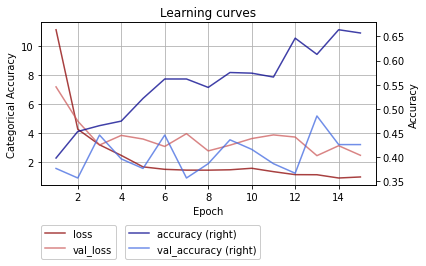

In [ ]:
#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn4.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training 
epochs = 15
history4 = cnn4.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist4 = pd.DataFrame.from_dict(history4.history)
df_hist4["Epoch"] = np.arange(1, len(df_hist4) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist4.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [ ]:
#visualize the model
visualkeras.layered_view(cnn4)

TypeError: ignored

Epoch 1/15


12/12 [==============================] - ETA: 0s - loss: 3.2568 - accuracy: 0.5148 - AUROC: 0.6680

12/12 [==============================] - 21s 1s/step - loss: 3.2568 - accuracy: 0.5148 - AUROC: 0.6680 - val_loss: 2.6672 - val_accuracy: 0.4257 - val_AUROC: 0.6205
Epoch 2/15
12/12 [==============================] - 17s 1s/step - loss: 0.9555 - accuracy: 0.6586 - AUROC: 0.8237 - val_loss: 2.3150 - val_accuracy: 0.4653 - val_AUROC: 0.6296
Epoch 3/15
12/12 [==============================] - 17s 1s/step - loss: 0.9840 - accuracy: 0.6425 - AUROC: 0.8210 - val_loss: 3.0293 - val_accuracy: 0.3861 - val_AUROC: 0.5894
Epoch 4/15
12/12 [==============================] - 17s 1s/step - loss: 0.9600 - accuracy: 0.6532 - AUROC: 0.8265 - val_loss: 2.3622 - val_accuracy: 0.4356 - val_AUROC: 0.6156
Epoch 5/15
12/12 [==============================] - 17s 1s/step - loss: 0.9691 - accuracy: 0.6465 - AUROC: 0.8217 - val_loss: 2.5308 - val_accuracy: 0.4158 - val_AUROC: 0.6161
Epoch 6/15
12/12 [==============================] - 17s 1s/step - loss: 0.9786 - accuracy: 0.6452 - AUROC: 0.8200 - val_loss: 2.772

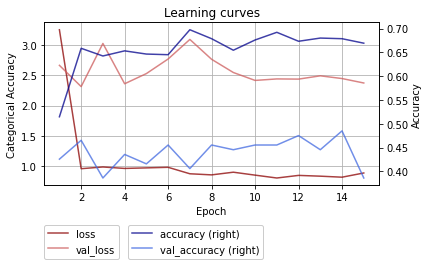

In [ ]:
# using adagrad

#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn4.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adagrad(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training 
epochs = 15
history41 = cnn4.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist41 = pd.DataFrame.from_dict(history41.history)
df_hist41["Epoch"] = np.arange(1, len(df_hist41) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist41.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Epoch 1/50


12/12 [==============================] - ETA: 0s - loss: 3.1433 - accuracy: 0.5282 - AUROC: 0.6871

12/12 [==============================] - 21s 1s/step - loss: 3.1433 - accuracy: 0.5282 - AUROC: 0.6871 - val_loss: 3.1218 - val_accuracy: 0.4554 - val_AUROC: 0.5905
Epoch 2/50
12/12 [==============================] - 17s 1s/step - loss: 0.9592 - accuracy: 0.6532 - AUROC: 0.8305 - val_loss: 2.6208 - val_accuracy: 0.4158 - val_AUROC: 0.6082
Epoch 3/50
12/12 [==============================] - 17s 1s/step - loss: 0.8220 - accuracy: 0.6815 - AUROC: 0.8576 - val_loss: 2.8723 - val_accuracy: 0.4158 - val_AUROC: 0.6186
Epoch 4/50
12/12 [==============================] - 17s 1s/step - loss: 0.8845 - accuracy: 0.6922 - AUROC: 0.8438 - val_loss: 2.8075 - val_accuracy: 0.4356 - val_AUROC: 0.6127
Epoch 5/50
12/12 [==============================] - 17s 1s/step - loss: 0.9013 - accuracy: 0.6653 - AUROC: 0.8362 - val_loss: 2.2148 - val_accuracy: 0.4653 - val_AUROC: 0.6378
Epoch 6/50
12/12 [==============================] - 17s 1s/step - loss: 0.7924 - accuracy: 0.6935 - AUROC: 0.8641 - val_loss: 2.587

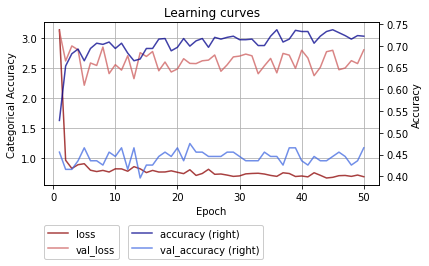

In [ ]:
# using adagrad + 50 epochs
#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn4.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adagrad(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training 
epochs = 50
history42 = cnn4.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist42 = pd.DataFrame.from_dict(history42.history)
df_hist42["Epoch"] = np.arange(1, len(df_hist42) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist42.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

CNN 5 | reintroducing batch normalization

In [ ]:
input_shape = tuple(batch_x_train.shape)

# Architecture CNN5
# dense layer activation = softmax
# hidden layers activation = relu 

cnn5 = Sequential([# Add data augmentation
                   augmentation,
                   # The batch normalization layer 
                   layers.BatchNormalization(), 
                   # Feature extraction
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn5.build(input_shape)

# Check network
cnn5.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (128, 128, 3)             0         
                                                                 
 batch_normalization_1 (Batc  (64, 128, 128, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_15 (Conv2D)          (64, 126, 126, 32)        896       
                                                                 
 activation_10 (Activation)  (64, 126, 126, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (64, 63, 63, 32)         0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (64, 61, 61, 64)         

Epoch 1/15


12/12 [==============================] - ETA: 0s - loss: 1.0984 - accuracy: 0.3965 - AUROC: 0.5811

12/12 [==============================] - 24s 2s/step - loss: 1.0984 - accuracy: 0.3965 - AUROC: 0.5811 - val_loss: 2.2845 - val_accuracy: 0.2673 - val_AUROC: 0.4990
Epoch 2/15
12/12 [==============================] - 20s 2s/step - loss: 1.0156 - accuracy: 0.4543 - AUROC: 0.6775 - val_loss: 1.2677 - val_accuracy: 0.3564 - val_AUROC: 0.5632
Epoch 3/15
12/12 [==============================] - 20s 2s/step - loss: 0.9817 - accuracy: 0.4785 - AUROC: 0.7019 - val_loss: 1.3031 - val_accuracy: 0.3762 - val_AUROC: 0.5562
Epoch 4/15
12/12 [==============================] - 22s 2s/step - loss: 0.9374 - accuracy: 0.5417 - AUROC: 0.7552 - val_loss: 1.0978 - val_accuracy: 0.4950 - val_AUROC: 0.6687
Epoch 5/15
12/12 [==============================] - 20s 2s/step - loss: 0.9260 - accuracy: 0.5390 - AUROC: 0.7486 - val_loss: 1.1338 - val_accuracy: 0.4257 - val_AUROC: 0.6583
Epoch 6/15
12/12 [==============================] - 20s 2s/step - loss: 0.8967 - accuracy: 0.6089 - AUROC: 0.7868 - val_loss: 1.064

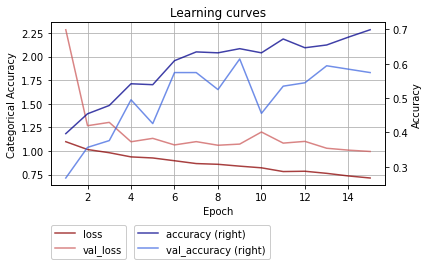

In [ ]:
#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn5.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training 
epochs = 15
history5 = cnn5.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist5 = pd.DataFrame.from_dict(history5.history)
df_hist5["Epoch"] = np.arange(1, len(df_hist5) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist5.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Epoch 1/30


12/12 [==============================] - ETA: 0s - loss: 1.0709 - accuracy: 0.4019 - AUROC: 0.5974

12/12 [==============================] - 18s 1s/step - loss: 1.0709 - accuracy: 0.4019 - AUROC: 0.5974 - val_loss: 1.8246 - val_accuracy: 0.2574 - val_AUROC: 0.4738
Epoch 2/30
12/12 [==============================] - 13s 1s/step - loss: 1.0289 - accuracy: 0.4382 - AUROC: 0.6535 - val_loss: 1.2879 - val_accuracy: 0.3663 - val_AUROC: 0.5183
Epoch 3/30
12/12 [==============================] - 13s 1s/step - loss: 0.9912 - accuracy: 0.4987 - AUROC: 0.6933 - val_loss: 1.1574 - val_accuracy: 0.4653 - val_AUROC: 0.5749
Epoch 4/30
12/12 [==============================] - 13s 1s/step - loss: 0.9873 - accuracy: 0.4812 - AUROC: 0.7024 - val_loss: 1.1094 - val_accuracy: 0.5446 - val_AUROC: 0.6480
Epoch 5/30
12/12 [==============================] - 13s 1s/step - loss: 0.9555 - accuracy: 0.5161 - AUROC: 0.7336 - val_loss: 1.0955 - val_accuracy: 0.5149 - val_AUROC: 0.6635
Epoch 6/30
12/12 [==============================] - 13s 1s/step - loss: 0.9211 - accuracy: 0.5887 - AUROC: 0.7729 - val_loss: 1.157

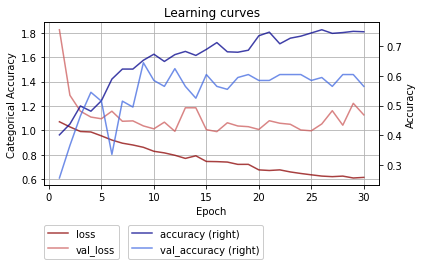

In [ ]:
#USING 30 EPOCHS

#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn5.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 30
history51 = cnn5.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist51 = pd.DataFrame.from_dict(history51.history)
df_hist51["Epoch"] = np.arange(1, len(df_hist51) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist51.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Epoch 1/15


12/12 [==============================] - ETA: 0s - loss: 0.4795 - accuracy: 0.8105 - AUROC: 0.9446

12/12 [==============================] - 24s 2s/step - loss: 0.4795 - accuracy: 0.8105 - AUROC: 0.9446 - val_loss: 1.0995 - val_accuracy: 0.5941 - val_AUROC: 0.7736
Epoch 2/15
12/12 [==============================] - 20s 2s/step - loss: 0.4590 - accuracy: 0.8266 - AUROC: 0.9519 - val_loss: 1.1146 - val_accuracy: 0.6040 - val_AUROC: 0.7751
Epoch 3/15
12/12 [==============================] - 20s 2s/step - loss: 0.4604 - accuracy: 0.8253 - AUROC: 0.9508 - val_loss: 1.1008 - val_accuracy: 0.6040 - val_AUROC: 0.7767
Epoch 4/15
12/12 [==============================] - 20s 2s/step - loss: 0.4463 - accuracy: 0.8280 - AUROC: 0.9555 - val_loss: 1.1182 - val_accuracy: 0.6139 - val_AUROC: 0.7750
Epoch 5/15
12/12 [==============================] - 20s 2s/step - loss: 0.4621 - accuracy: 0.8253 - AUROC: 0.9495 - val_loss: 1.1131 - val_accuracy: 0.6040 - val_AUROC: 0.7746
Epoch 6/15
12/12 [==============================] - 20s 2s/step - loss: 0.4496 - accuracy: 0.8347 - AUROC: 0.9529 - val_loss: 1.118

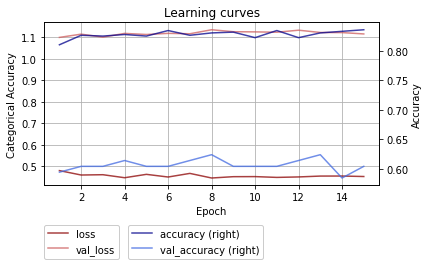

In [ ]:
# using adagrad

#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn5.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adagrad(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training 
epochs = 15
history52 = cnn5.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist52 = pd.DataFrame.from_dict(history52.history)
df_hist52["Epoch"] = np.arange(1, len(df_hist52) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist52.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Epoch 1/30


12/12 [==============================] - ETA: 0s - loss: 0.4539 - accuracy: 0.8387 - AUROC: 0.9524

12/12 [==============================] - 24s 2s/step - loss: 0.4539 - accuracy: 0.8387 - AUROC: 0.9524 - val_loss: 1.1384 - val_accuracy: 0.6139 - val_AUROC: 0.7735
Epoch 2/30
12/12 [==============================] - 20s 2s/step - loss: 0.4478 - accuracy: 0.8347 - AUROC: 0.9539 - val_loss: 1.1359 - val_accuracy: 0.6238 - val_AUROC: 0.7733
Epoch 3/30
12/12 [==============================] - 20s 2s/step - loss: 0.4336 - accuracy: 0.8293 - AUROC: 0.9581 - val_loss: 1.1350 - val_accuracy: 0.6238 - val_AUROC: 0.7743
Epoch 4/30
12/12 [==============================] - 23s 2s/step - loss: 0.4543 - accuracy: 0.8239 - AUROC: 0.9518 - val_loss: 1.1321 - val_accuracy: 0.6139 - val_AUROC: 0.7734
Epoch 5/30
12/12 [==============================] - 21s 2s/step - loss: 0.4539 - accuracy: 0.8159 - AUROC: 0.9503 - val_loss: 1.1161 - val_accuracy: 0.6040 - val_AUROC: 0.7737
Epoch 6/30
12/12 [==============================] - 20s 2s/step - loss: 0.4642 - accuracy: 0.8212 - AUROC: 0.9480 - val_loss: 1.135

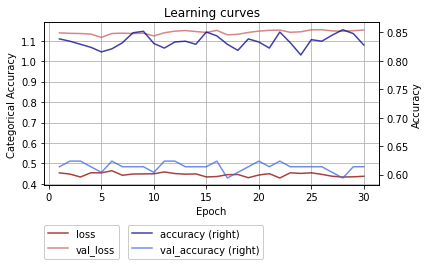

In [ ]:
# using adagrad and 30 epochs

#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn5.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adagrad(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training 
epochs = 30
history53 = cnn5.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist53 = pd.DataFrame.from_dict(history53.history)
df_hist53["Epoch"] = np.arange(1, len(df_hist53) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist53.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

CNN 6 | regularizers

One way to prevent overfitting is to use regularization

In [ ]:
input_shape = tuple(batch_x_train.shape)

# Architecture CNN6
# dense layer activation = softmax
# hidden layers activation = relu 

cnn6 = Sequential([
                   augmentation, 
                   layers.BatchNormalization(), 
                   # Feature extraction
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer=regularizers.L2(1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn6.build(input_shape)

# Check network
cnn6.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (128, 128, 3)             0         
                                                                 
 batch_normalization_9 (Batc  (64, 128, 128, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_133 (Conv2D)         (64, 126, 126, 32)        896       
                                                                 
 activation_2 (Activation)   (64, 126, 126, 32)        0         
                                                                 
 max_pooling2d_74 (MaxPoolin  (64, 63, 63, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_134 (Conv2D)         (64, 61, 61, 64)        

Epoch 1/15


12/12 [==============================] - ETA: 0s - loss: 1.1499 - accuracy: 0.3525 - AUROC: 0.5496

12/12 [==============================] - 9s 415ms/step - loss: 1.1499 - accuracy: 0.3525 - AUROC: 0.5496 - val_loss: 1.9375 - val_accuracy: 0.2673 - val_AUROC: 0.3930
Epoch 2/15
12/12 [==============================] - 5s 358ms/step - loss: 1.0611 - accuracy: 0.4331 - AUROC: 0.6215 - val_loss: 1.1019 - val_accuracy: 0.4752 - val_AUROC: 0.5986
Epoch 3/15
12/12 [==============================] - 5s 366ms/step - loss: 1.0306 - accuracy: 0.4454 - AUROC: 0.6519 - val_loss: 1.2171 - val_accuracy: 0.3861 - val_AUROC: 0.5300
Epoch 4/15
12/12 [==============================] - 9s 690ms/step - loss: 0.9987 - accuracy: 0.4918 - AUROC: 0.7084 - val_loss: 1.1014 - val_accuracy: 0.3960 - val_AUROC: 0.6100
Epoch 5/15
12/12 [==============================] - 5s 357ms/step - loss: 0.9695 - accuracy: 0.5232 - AUROC: 0.7327 - val_loss: 1.1191 - val_accuracy: 0.3960 - val_AUROC: 0.6287
Epoch 6/15
12/12 [==============================] - 5s 369ms/step - loss: 0.9513 - accuracy: 0.5697 - AUROC: 0.7486 - val

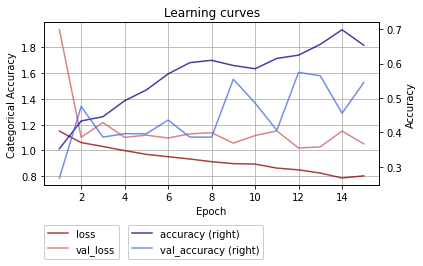

In [ ]:
#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn6.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 15
history6 = cnn6.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist6 = pd.DataFrame.from_dict(history6.history)
df_hist6["Epoch"] = np.arange(1, len(df_hist6) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist6.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [ ]:
#visualize the model
visualkeras.layered_view(cnn6)

TypeError: ignored

Epoch 1/50


12/12 [==============================] - ETA: 0s - loss: 1.0940 - accuracy: 0.4249 - AUROC: 0.5935

12/12 [==============================] - 9s 385ms/step - loss: 1.0940 - accuracy: 0.4249 - AUROC: 0.5935 - val_loss: 1.2201 - val_accuracy: 0.3465 - val_AUROC: 0.6098
Epoch 2/50
12/12 [==============================] - 5s 366ms/step - loss: 1.0431 - accuracy: 0.4317 - AUROC: 0.6475 - val_loss: 1.4549 - val_accuracy: 0.4653 - val_AUROC: 0.5528
Epoch 3/50
12/12 [==============================] - 5s 360ms/step - loss: 0.9857 - accuracy: 0.5137 - AUROC: 0.7126 - val_loss: 1.0579 - val_accuracy: 0.5644 - val_AUROC: 0.6996
Epoch 4/50
12/12 [==============================] - 5s 364ms/step - loss: 0.9627 - accuracy: 0.5560 - AUROC: 0.7406 - val_loss: 1.1990 - val_accuracy: 0.3366 - val_AUROC: 0.6162
Epoch 5/50
12/12 [==============================] - 5s 362ms/step - loss: 0.9284 - accuracy: 0.5943 - AUROC: 0.7676 - val_loss: 1.0719 - val_accuracy: 0.5842 - val_AUROC: 0.7031
Epoch 6/50
12/12 [==============================] - 5s 386ms/step - loss: 0.9012 - accuracy: 0.6093 - AUROC: 0.7842 - val

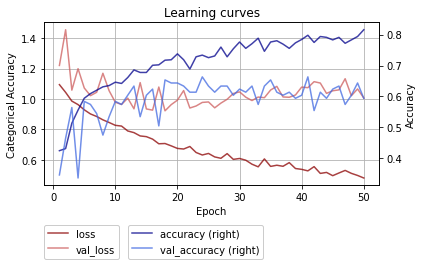

In [ ]:
#using 50 epochs

#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn6.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 50
history62 = cnn6.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist62 = pd.DataFrame.from_dict(history62.history)
df_hist62["Epoch"] = np.arange(1, len(df_hist62) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist62.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Epoch 1/15


12/12 [==============================] - ETA: 0s - loss: 0.4381 - accuracy: 0.8360 - AUROC: 0.9544

12/12 [==============================] - 24s 2s/step - loss: 0.4381 - accuracy: 0.8360 - AUROC: 0.9544 - val_loss: 1.1906 - val_accuracy: 0.6139 - val_AUROC: 0.7603
Epoch 2/15
12/12 [==============================] - 20s 2s/step - loss: 0.4275 - accuracy: 0.8575 - AUROC: 0.9578 - val_loss: 1.1678 - val_accuracy: 0.5941 - val_AUROC: 0.7565
Epoch 3/15
12/12 [==============================] - 20s 2s/step - loss: 0.4250 - accuracy: 0.8441 - AUROC: 0.9597 - val_loss: 1.2147 - val_accuracy: 0.6139 - val_AUROC: 0.7578
Epoch 4/15
12/12 [==============================] - 20s 2s/step - loss: 0.4178 - accuracy: 0.8629 - AUROC: 0.9608 - val_loss: 1.1962 - val_accuracy: 0.6040 - val_AUROC: 0.7592
Epoch 5/15
12/12 [==============================] - 20s 2s/step - loss: 0.4111 - accuracy: 0.8575 - AUROC: 0.9638 - val_loss: 1.2114 - val_accuracy: 0.6040 - val_AUROC: 0.7582
Epoch 6/15
12/12 [==============================] - 20s 2s/step - loss: 0.4127 - accuracy: 0.8562 - AUROC: 0.9626 - val_loss: 1.205

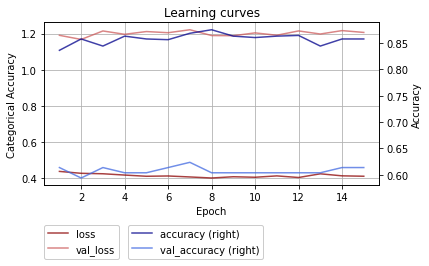

In [ ]:
#using adagrad

#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn6.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adagrad(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 15
history61 = cnn6.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist61 = pd.DataFrame.from_dict(history61.history)
df_hist61["Epoch"] = np.arange(1, len(df_hist61) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist61.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Epoch 1/30


12/12 [==============================] - ETA: 0s - loss: 0.4124 - accuracy: 0.8696 - AUROC: 0.9632

12/12 [==============================] - 24s 2s/step - loss: 0.4124 - accuracy: 0.8696 - AUROC: 0.9632 - val_loss: 1.2175 - val_accuracy: 0.6139 - val_AUROC: 0.7604
Epoch 2/30
12/12 [==============================] - 20s 2s/step - loss: 0.4108 - accuracy: 0.8562 - AUROC: 0.9628 - val_loss: 1.1891 - val_accuracy: 0.5941 - val_AUROC: 0.7575
Epoch 3/30
12/12 [==============================] - 20s 2s/step - loss: 0.4197 - accuracy: 0.8454 - AUROC: 0.9611 - val_loss: 1.2089 - val_accuracy: 0.6139 - val_AUROC: 0.7588
Epoch 4/30
12/12 [==============================] - 20s 2s/step - loss: 0.4100 - accuracy: 0.8495 - AUROC: 0.9626 - val_loss: 1.2156 - val_accuracy: 0.6040 - val_AUROC: 0.7570
Epoch 5/30
12/12 [==============================] - 20s 2s/step - loss: 0.4162 - accuracy: 0.8508 - AUROC: 0.9602 - val_loss: 1.1965 - val_accuracy: 0.6139 - val_AUROC: 0.7525
Epoch 6/30
12/12 [==============================] - 22s 2s/step - loss: 0.4070 - accuracy: 0.8427 - AUROC: 0.9632 - val_loss: 1.195

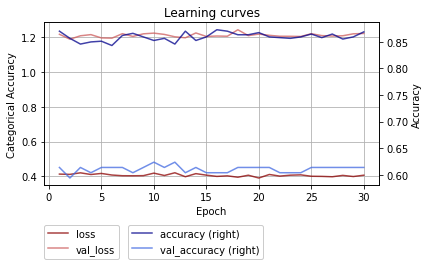

In [ ]:
#using adagrad and 30 epochs

#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn6.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adagrad(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 30
history62 = cnn6.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist62 = pd.DataFrame.from_dict(history62.history)
df_hist62["Epoch"] = np.arange(1, len(df_hist62) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist62.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

CNN 6.0.1 | Experimenting kernel size variation

In [ ]:
input_shape = tuple(batch_x_train.shape)

# Architecture CNN6
# dense layer activation = softmax
# hidden layers activation = relu
# 1st Conv2D kernel size -> (5,5) 

cnn601 = Sequential([
                   augmentation, 
                   layers.BatchNormalization(), 
                   # Feature extraction
                   layers.Conv2D(filters=32, kernel_size=(5, 5),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer=regularizers.L2(1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn601.build(input_shape)

# Check network
cnn601.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (128, 128, 3)             0         
                                                                 
 batch_normalization_3 (Batc  (64, 128, 128, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_12 (Conv2D)          (64, 124, 124, 32)        2432      
                                                                 
 activation_12 (Activation)  (64, 124, 124, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (64, 62, 62, 32)         0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (64, 60, 60, 64)         

Epoch 1/30


12/12 [==============================] - ETA: 0s - loss: 1.1066 - accuracy: 0.3750 - AUROC: 0.5735

12/12 [==============================] - 30s 2s/step - loss: 1.1066 - accuracy: 0.3750 - AUROC: 0.5735 - val_loss: 1.8394 - val_accuracy: 0.4653 - val_AUROC: 0.5942
Epoch 2/30
12/12 [==============================] - 24s 2s/step - loss: 1.0210 - accuracy: 0.4570 - AUROC: 0.6769 - val_loss: 1.3318 - val_accuracy: 0.4356 - val_AUROC: 0.5792
Epoch 3/30
12/12 [==============================] - 24s 2s/step - loss: 0.9758 - accuracy: 0.5349 - AUROC: 0.7288 - val_loss: 1.4140 - val_accuracy: 0.3861 - val_AUROC: 0.5802
Epoch 4/30
12/12 [==============================] - 24s 2s/step - loss: 0.9461 - accuracy: 0.5228 - AUROC: 0.7403 - val_loss: 1.1080 - val_accuracy: 0.5149 - val_AUROC: 0.6864
Epoch 5/30
12/12 [==============================] - 26s 2s/step - loss: 0.9223 - accuracy: 0.5780 - AUROC: 0.7622 - val_loss: 1.2225 - val_accuracy: 0.4158 - val_AUROC: 0.6263
Epoch 6/30
12/12 [==============================] - 25s 2s/step - loss: 0.9298 - accuracy: 0.5645 - AUROC: 0.7476 - val_loss: 1.205

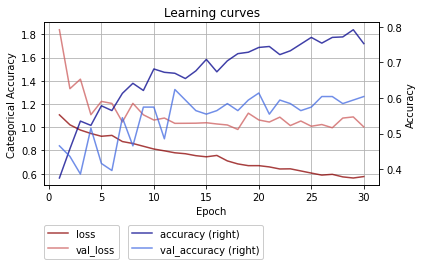

In [ ]:
#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn601.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 30
history601 = cnn601.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist601 = pd.DataFrame.from_dict(history601.history)
df_hist601["Epoch"] = np.arange(1, len(df_hist601) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist601.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

CNN 6.1 | GOING DEPPER (1 MORE LAYER)

In [ ]:
input_shape = tuple(batch_x_train.shape)

# Architecture CNN6
# dense layer activation = softmax
# hidden layers activation = relu 

cnn61 = Sequential([
                   augmentation, 
                   layers.BatchNormalization(), 
                   # Feature extraction
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer=regularizers.L2(1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn61.build(input_shape)

# Check network
cnn61.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (128, 128, 3)             0         
                                                                 
 batch_normalization_4 (Batc  (64, 128, 128, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_14 (Conv2D)          (64, 126, 126, 32)        896       
                                                                 
 activation_14 (Activation)  (64, 126, 126, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (64, 63, 63, 32)         0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (64, 61, 61, 64)         

Epoch 1/30


12/12 [==============================] - ETA: 0s - loss: 1.0883 - accuracy: 0.3884 - AUROC: 0.5887

12/12 [==============================] - 28s 2s/step - loss: 1.0883 - accuracy: 0.3884 - AUROC: 0.5887 - val_loss: 1.1908 - val_accuracy: 0.3861 - val_AUROC: 0.5923
Epoch 2/30
12/12 [==============================] - 24s 2s/step - loss: 1.0331 - accuracy: 0.4126 - AUROC: 0.6525 - val_loss: 1.3068 - val_accuracy: 0.3366 - val_AUROC: 0.5583
Epoch 3/30
12/12 [==============================] - 24s 2s/step - loss: 0.9836 - accuracy: 0.5282 - AUROC: 0.7164 - val_loss: 1.1833 - val_accuracy: 0.3762 - val_AUROC: 0.5951
Epoch 4/30
12/12 [==============================] - 24s 2s/step - loss: 0.9413 - accuracy: 0.5618 - AUROC: 0.7495 - val_loss: 1.2318 - val_accuracy: 0.4950 - val_AUROC: 0.6247
Epoch 5/30
12/12 [==============================] - 24s 2s/step - loss: 0.8942 - accuracy: 0.5874 - AUROC: 0.7845 - val_loss: 1.4270 - val_accuracy: 0.4455 - val_AUROC: 0.6117
Epoch 6/30
12/12 [==============================] - 24s 2s/step - loss: 0.8586 - accuracy: 0.6210 - AUROC: 0.7987 - val_loss: 1.144

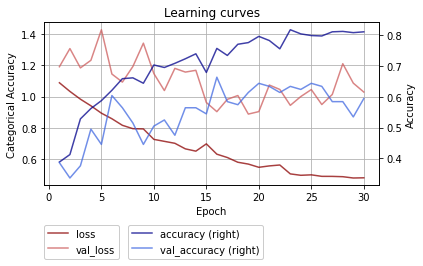

In [ ]:
#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn61.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 30
history611 = cnn61.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist611 = pd.DataFrame.from_dict(history611.history)
df_hist611["Epoch"] = np.arange(1, len(df_hist611) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist611.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

CNN 6.2 | GOING DEPPER (1 MORE LAYER + kernel size variation)

In [ ]:
input_shape = tuple(batch_x_train.shape)

# Architecture CNN6
# dense layer activation = softmax
# hidden layers activation = relu 

cnn62 = Sequential([
                   augmentation, 
                   layers.BatchNormalization(), 
                   # Feature extraction
                   layers.Conv2D(filters=32, kernel_size=(5, 5),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer=regularizers.L2(1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn62.build(input_shape)

# Check network
cnn62.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (128, 128, 3)             0         
                                                                 
 batch_normalization_5 (Batc  (64, 128, 128, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_17 (Conv2D)          (64, 124, 124, 32)        2432      
                                                                 
 activation_17 (Activation)  (64, 124, 124, 32)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (64, 62, 62, 32)         0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (64, 60, 60, 64)         

Epoch 1/30


12/12 [==============================] - ETA: 0s - loss: 1.1492 - accuracy: 0.3938 - AUROC: 0.5441

12/12 [==============================] - 33s 2s/step - loss: 1.1492 - accuracy: 0.3938 - AUROC: 0.5441 - val_loss: 1.0827 - val_accuracy: 0.4653 - val_AUROC: 0.6319
Epoch 2/30
12/12 [==============================] - 28s 2s/step - loss: 1.0494 - accuracy: 0.4462 - AUROC: 0.6505 - val_loss: 1.4079 - val_accuracy: 0.3069 - val_AUROC: 0.4964
Epoch 3/30
12/12 [==============================] - 28s 2s/step - loss: 1.0138 - accuracy: 0.5027 - AUROC: 0.6934 - val_loss: 1.3963 - val_accuracy: 0.3663 - val_AUROC: 0.5411
Epoch 4/30
12/12 [==============================] - 28s 2s/step - loss: 0.9743 - accuracy: 0.5430 - AUROC: 0.7236 - val_loss: 1.2123 - val_accuracy: 0.5644 - val_AUROC: 0.6380
Epoch 5/30
12/12 [==============================] - 28s 2s/step - loss: 0.9435 - accuracy: 0.5605 - AUROC: 0.7492 - val_loss: 1.2051 - val_accuracy: 0.5941 - val_AUROC: 0.6792
Epoch 6/30
12/12 [==============================] - 28s 2s/step - loss: 0.8939 - accuracy: 0.6089 - AUROC: 0.7899 - val_loss: 1.847

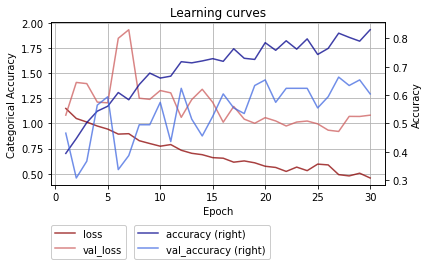

In [ ]:
#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn62.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 30
history62 = cnn62.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist62 = pd.DataFrame.from_dict(history62.history)
df_hist62["Epoch"] = np.arange(1, len(df_hist62) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist62.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

CNN 7 | GOING DEEPER (2 MORE LAYERS)

In [ ]:
input_shape = tuple(batch_x_train.shape)

# Architecture CNN7
# dense layer activation = softmax
# hidden layers activation = relu 

cnn7 = Sequential([
                   augmentation, 
                   layers.BatchNormalization(), 
                   # Feature extraction
                   layers.Conv2D(filters=32, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer=regularizers.L2(1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

# Builds the DAG
cnn7.build(input_shape)

# Check network
cnn7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (128, 128, 3)             0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 activation (Activation)     (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        1

Epoch 1/50


12/12 [==============================] - ETA: 0s - loss: 1.1072 - accuracy: 0.3790 - AUROC: 0.5737

12/12 [==============================] - 29s 2s/step - loss: 1.1072 - accuracy: 0.3790 - AUROC: 0.5737 - val_loss: 1.3128 - val_accuracy: 0.3465 - val_AUROC: 0.5567
Epoch 2/50
12/12 [==============================] - 24s 2s/step - loss: 1.0398 - accuracy: 0.4677 - AUROC: 0.6692 - val_loss: 1.2397 - val_accuracy: 0.5248 - val_AUROC: 0.6695
Epoch 3/50
12/12 [==============================] - 24s 2s/step - loss: 0.9789 - accuracy: 0.4879 - AUROC: 0.7224 - val_loss: 1.2100 - val_accuracy: 0.4851 - val_AUROC: 0.6869
Epoch 4/50
12/12 [==============================] - 24s 2s/step - loss: 0.9186 - accuracy: 0.5739 - AUROC: 0.7636 - val_loss: 2.2484 - val_accuracy: 0.3564 - val_AUROC: 0.5900
Epoch 5/50
12/12 [==============================] - 24s 2s/step - loss: 0.8768 - accuracy: 0.5847 - AUROC: 0.7875 - val_loss: 1.3700 - val_accuracy: 0.4554 - val_AUROC: 0.6399
Epoch 6/50
12/12 [==============================] - 24s 2s/step - loss: 0.8001 - accuracy: 0.6532 - AUROC: 0.8317 - val_loss: 3.341

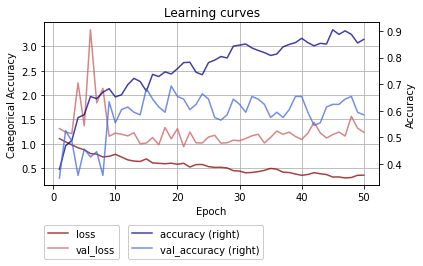

In [ ]:
#using ADAM and 50 epochs

#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn7.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 50
history7 = cnn7.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist7 = pd.DataFrame.from_dict(history7.history)
df_hist7["Epoch"] = np.arange(1, len(df_hist7) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist7.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Epoch 1/50


12/12 [==============================] - ETA: 0s - loss: 1.1248 - accuracy: 0.3427 - AUROC: 0.4969

12/12 [==============================] - 22s 716ms/step - loss: 1.1248 - accuracy: 0.3427 - AUROC: 0.4969 - val_loss: 1.2804 - val_accuracy: 0.3366 - val_AUROC: 0.5245
Epoch 2/50
12/12 [==============================] - 5s 356ms/step - loss: 1.1060 - accuracy: 0.3401 - AUROC: 0.5593 - val_loss: 1.1736 - val_accuracy: 0.3366 - val_AUROC: 0.5512
Epoch 3/50
12/12 [==============================] - 7s 501ms/step - loss: 1.1003 - accuracy: 0.3548 - AUROC: 0.5722 - val_loss: 1.1361 - val_accuracy: 0.3960 - val_AUROC: 0.5892
Epoch 4/50
12/12 [==============================] - 5s 439ms/step - loss: 1.0951 - accuracy: 0.3777 - AUROC: 0.5829 - val_loss: 1.1163 - val_accuracy: 0.4059 - val_AUROC: 0.5998
Epoch 5/50
12/12 [==============================] - 6s 392ms/step - loss: 1.0940 - accuracy: 0.3562 - AUROC: 0.5827 - val_loss: 1.0986 - val_accuracy: 0.4059 - val_AUROC: 0.6193
Epoch 6/50
12/12 [==============================] - 6s 508ms/step - loss: 1.0915 - accuracy: 0.3804 - AUROC: 0.5924 - va

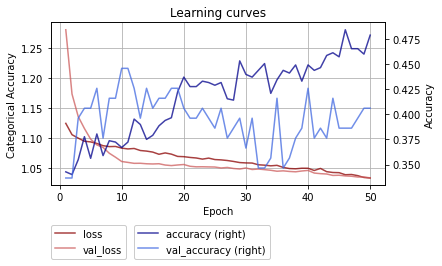

In [ ]:
#using adagrad and 50 epochs

#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn7.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adagrad(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 50
history7 = cnn7.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist7 = pd.DataFrame.from_dict(history7.history)
df_hist7["Epoch"] = np.arange(1, len(df_hist7) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist7.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

In [ ]:
#using adagrad and 500 epochs

#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn7.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adagrad(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 500
history7 = cnn7.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist7 = pd.DataFrame.from_dict(history7.history)
df_hist7["Epoch"] = np.arange(1, len(df_hist7) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist7.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Epoch 1/500


12/12 [==============================] - ETA: 0s - loss: 1.0372 - accuracy: 0.4570 - AUROC: 0.6725

12/12 [==============================] - 9s 528ms/step - loss: 1.0372 - accuracy: 0.4570 - AUROC: 0.6725 - val_loss: 1.0339 - val_accuracy: 0.4257 - val_AUROC: 0.6745
Epoch 2/500
12/12 [==============================] - 5s 374ms/step - loss: 1.0315 - accuracy: 0.4839 - AUROC: 0.6884 - val_loss: 1.0309 - val_accuracy: 0.4059 - val_AUROC: 0.6707
Epoch 3/500
12/12 [==============================] - 6s 476ms/step - loss: 1.0293 - accuracy: 0.4704 - AUROC: 0.6890 - val_loss: 1.0295 - val_accuracy: 0.4158 - val_AUROC: 0.6688
Epoch 4/500
12/12 [==============================] - 6s 450ms/step - loss: 1.0284 - accuracy: 0.4772 - AUROC: 0.6875 - val_loss: 1.0293 - val_accuracy: 0.4158 - val_AUROC: 0.6710
Epoch 5/500
12/12 [==============================] - 5s 382ms/step - loss: 1.0277 - accuracy: 0.4919 - AUROC: 0.6861 - val_loss: 1.0284 - val_accuracy: 0.4257 - val_AUROC: 0.6792
Epoch 6/500
12/12 [==============================] - 5s 375ms/step - loss: 1.0264 - accuracy: 0.5000 - AUROC: 0.6924 

KeyboardInterrupt: ignored

CNN 7.1 | GOING DEEPER (2 MORE LAYERS + Kernel size variation)

In [ ]:
input_shape = tuple(batch_x_train.shape)

# Architecture CNN7
# dense layer activation = softmax
# hidden layers activation = relu 

cnn71 = Sequential([
                   augmentation, 
                   layers.BatchNormalization(), 
                   # Feature extraction
                   layers.Conv2D(filters=32, kernel_size=(11,11),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(5, 5),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer=regularizers.L2(1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn71.build(input_shape)

# Check network
cnn71.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (128, 128, 3)             0         
                                                                 
 batch_normalization_1 (Batc  (64, 128, 128, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (64, 118, 118, 32)        11648     
                                                                 
 activation_4 (Activation)   (64, 118, 118, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (64, 59, 59, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (64, 55, 55, 64)         

Epoch 1/15


12/12 [==============================] - ETA: 0s - loss: 1.1125 - accuracy: 0.3723 - AUROC: 0.5698

12/12 [==============================] - 16s 911ms/step - loss: 1.1125 - accuracy: 0.3723 - AUROC: 0.5698 - val_loss: 1.3785 - val_accuracy: 0.4950 - val_AUROC: 0.6587
Epoch 2/15
12/12 [==============================] - 8s 612ms/step - loss: 1.0694 - accuracy: 0.4301 - AUROC: 0.6289 - val_loss: 1.5981 - val_accuracy: 0.3762 - val_AUROC: 0.5530
Epoch 3/15
12/12 [==============================] - 5s 391ms/step - loss: 1.0257 - accuracy: 0.4933 - AUROC: 0.6792 - val_loss: 1.6353 - val_accuracy: 0.4257 - val_AUROC: 0.6122
Epoch 4/15
12/12 [==============================] - 5s 385ms/step - loss: 1.0336 - accuracy: 0.4718 - AUROC: 0.6812 - val_loss: 1.0517 - val_accuracy: 0.5446 - val_AUROC: 0.6897
Epoch 5/15
12/12 [==============================] - 6s 514ms/step - loss: 0.9995 - accuracy: 0.5269 - AUROC: 0.7145 - val_loss: 1.7302 - val_accuracy: 0.3762 - val_AUROC: 0.5759
Epoch 6/15
12/12 [==============================] - 5s 393ms/step - loss: 0.9800 - accuracy: 0.5511 - AUROC: 0.7271 - va

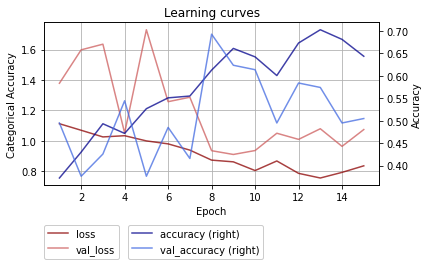

In [ ]:
#using ADAM and 15 epochs

#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn71.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 15
history71 = cnn71.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist71 = pd.DataFrame.from_dict(history71.history)
df_hist71["Epoch"] = np.arange(1, len(df_hist71) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist71.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Epoch 1/50


12/12 [==============================] - ETA: 0s - loss: 0.7930 - accuracy: 0.6828 - AUROC: 0.8294

12/12 [==============================] - 10s 530ms/step - loss: 0.7930 - accuracy: 0.6828 - AUROC: 0.8294 - val_loss: 1.0342 - val_accuracy: 0.5644 - val_AUROC: 0.7475
Epoch 2/50
12/12 [==============================] - 5s 383ms/step - loss: 0.7218 - accuracy: 0.7272 - AUROC: 0.8684 - val_loss: 0.9403 - val_accuracy: 0.5842 - val_AUROC: 0.8024
Epoch 3/50
12/12 [==============================] - 6s 503ms/step - loss: 0.6889 - accuracy: 0.7419 - AUROC: 0.8808 - val_loss: 0.9690 - val_accuracy: 0.5842 - val_AUROC: 0.7941
Epoch 4/50
12/12 [==============================] - 5s 388ms/step - loss: 0.6947 - accuracy: 0.7446 - AUROC: 0.8824 - val_loss: 1.0074 - val_accuracy: 0.6139 - val_AUROC: 0.7891
Epoch 5/50
12/12 [==============================] - 6s 516ms/step - loss: 0.6420 - accuracy: 0.7460 - AUROC: 0.8946 - val_loss: 0.9271 - val_accuracy: 0.5842 - val_AUROC: 0.8014
Epoch 6/50
12/12 [==============================] - 6s 464ms/step - loss: 0.6399 - accuracy: 0.7608 - AUROC: 0.8966 - va

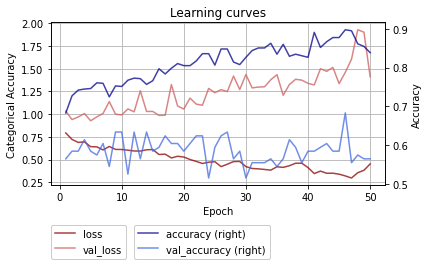

In [ ]:
#using ADAM and 50 epochs

#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn71.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 50
history711 = cnn71.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist711 = pd.DataFrame.from_dict(history711.history)
df_hist711["Epoch"] = np.arange(1, len(df_hist711) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist711.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Epoch 1/50


12/12 [==============================] - ETA: 0s - loss: 0.2897 - accuracy: 0.9046 - AUROC: 0.9805

12/12 [==============================] - 9s 533ms/step - loss: 0.2897 - accuracy: 0.9046 - AUROC: 0.9805 - val_loss: 1.3767 - val_accuracy: 0.5743 - val_AUROC: 0.7887
Epoch 2/50
12/12 [==============================] - 5s 379ms/step - loss: 0.2559 - accuracy: 0.9140 - AUROC: 0.9859 - val_loss: 1.3651 - val_accuracy: 0.5644 - val_AUROC: 0.7928
Epoch 3/50
12/12 [==============================] - 6s 509ms/step - loss: 0.2636 - accuracy: 0.9153 - AUROC: 0.9850 - val_loss: 1.3575 - val_accuracy: 0.5842 - val_AUROC: 0.7940
Epoch 4/50
12/12 [==============================] - 5s 374ms/step - loss: 0.2658 - accuracy: 0.9180 - AUROC: 0.9838 - val_loss: 1.3528 - val_accuracy: 0.5842 - val_AUROC: 0.7958
Epoch 5/50
12/12 [==============================] - 5s 383ms/step - loss: 0.2547 - accuracy: 0.9140 - AUROC: 0.9862 - val_loss: 1.3621 - val_accuracy: 0.5644 - val_AUROC: 0.7943
Epoch 6/50
12/12 [==============================] - 6s 462ms/step - loss: 0.2227 - accuracy: 0.9355 - AUROC: 0.9899 - val

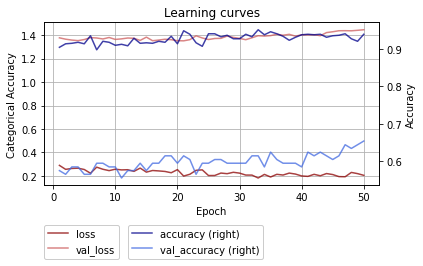

In [ ]:
#using adagrad and 50 epochs

#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn71.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adagrad(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 50
history712 = cnn71.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist712 = pd.DataFrame.from_dict(history712.history)
df_hist712["Epoch"] = np.arange(1, len(df_hist712) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist712.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

*CNN* 7.2 | GOING DEEPER (2 MORE LAYERS + Kernel size variation + filters variaton)

In [ ]:
input_shape = tuple(batch_x_train.shape)

# Architecture CNN7
# dense layer activation = softmax
# hidden layers activation = relu 

cnn72 = Sequential([
                   augmentation, 
                   layers.BatchNormalization(), 
                   # Feature extraction
                   layers.Conv2D(filters=64, kernel_size=(11,11),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=128, kernel_size=(5, 5),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer=regularizers.L2(1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn72.build(input_shape)

# Check network
cnn72.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (128, 128, 3)             0         
                                                                 
 batch_normalization_10 (Bat  (64, 128, 128, 3)        12        
 chNormalization)                                                
                                                                 
 conv2d_135 (Conv2D)         (64, 118, 118, 64)        23296     
                                                                 
 activation_4 (Activation)   (64, 118, 118, 64)        0         
                                                                 
 max_pooling2d_75 (MaxPoolin  (64, 59, 59, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_136 (Conv2D)         (64, 55, 55, 128)       

Epoch 1/15


12/12 [==============================] - ETA: 0s - loss: 1.1865 - accuracy: 0.3689 - AUROC: 0.5504

12/12 [==============================] - 12s 539ms/step - loss: 1.1865 - accuracy: 0.3689 - AUROC: 0.5504 - val_loss: 2.2502 - val_accuracy: 0.3366 - val_AUROC: 0.4652
Epoch 2/15
12/12 [==============================] - 5s 398ms/step - loss: 1.1256 - accuracy: 0.3825 - AUROC: 0.5660 - val_loss: 1.4223 - val_accuracy: 0.2772 - val_AUROC: 0.4503
Epoch 3/15
12/12 [==============================] - 5s 396ms/step - loss: 1.1006 - accuracy: 0.4139 - AUROC: 0.5990 - val_loss: 1.5805 - val_accuracy: 0.2673 - val_AUROC: 0.4807
Epoch 4/15
12/12 [==============================] - 5s 400ms/step - loss: 1.0928 - accuracy: 0.4071 - AUROC: 0.6141 - val_loss: 1.3333 - val_accuracy: 0.2673 - val_AUROC: 0.4833
Epoch 5/15
12/12 [==============================] - 5s 394ms/step - loss: 1.0765 - accuracy: 0.4508 - AUROC: 0.6361 - val_loss: 1.1145 - val_accuracy: 0.4158 - val_AUROC: 0.6211
Epoch 6/15
12/12 [==============================] - 5s 399ms/step - loss: 1.0685 - accuracy: 0.4631 - AUROC: 0.6653 - va

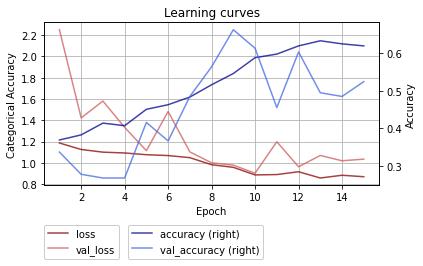

In [ ]:
#using ADAM and 15 epochs

#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn72.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 15
history72 = cnn72.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist72 = pd.DataFrame.from_dict(history72.history)
df_hist72["Epoch"] = np.arange(1, len(df_hist72) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist72.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Epoch 1/30


12/12 [==============================] - ETA: 0s - loss: 1.1771 - accuracy: 0.3293 - AUROC: 0.5460

12/12 [==============================] - 13s 641ms/step - loss: 1.1771 - accuracy: 0.3293 - AUROC: 0.5460 - val_loss: 1.1221 - val_accuracy: 0.3564 - val_AUROC: 0.5629
Epoch 2/30
12/12 [==============================] - 6s 480ms/step - loss: 1.1119 - accuracy: 0.3817 - AUROC: 0.5880 - val_loss: 1.2139 - val_accuracy: 0.3366 - val_AUROC: 0.5430
Epoch 3/30
12/12 [==============================] - 6s 405ms/step - loss: 1.1059 - accuracy: 0.3858 - AUROC: 0.5893 - val_loss: 1.0932 - val_accuracy: 0.5248 - val_AUROC: 0.6234
Epoch 4/30
12/12 [==============================] - 7s 536ms/step - loss: 1.1005 - accuracy: 0.3858 - AUROC: 0.5930 - val_loss: 1.1806 - val_accuracy: 0.3069 - val_AUROC: 0.5089
Epoch 5/30
12/12 [==============================] - 5s 400ms/step - loss: 1.0973 - accuracy: 0.4167 - AUROC: 0.6106 - val_loss: 1.1681 - val_accuracy: 0.2970 - val_AUROC: 0.4823
Epoch 6/30
12/12 [==============================] - 5s 412ms/step - loss: 1.0877 - accuracy: 0.3817 - AUROC: 0.6154 - va

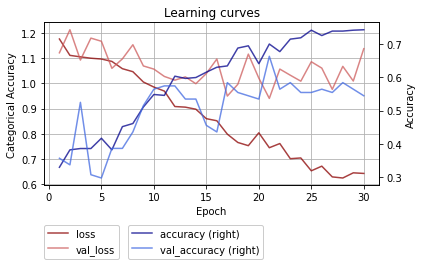

In [ ]:
#using ADAM and 30 epochs

#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn72.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 30
history721 = cnn72.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist721 = pd.DataFrame.from_dict(history721.history)
df_hist721["Epoch"] = np.arange(1, len(df_hist721) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist721.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Epoch 1/60


12/12 [==============================] - ETA: 0s - loss: 0.6787 - accuracy: 0.7191 - AUROC: 0.8836

12/12 [==============================] - 10s 558ms/step - loss: 0.6787 - accuracy: 0.7191 - AUROC: 0.8836 - val_loss: 1.0661 - val_accuracy: 0.5446 - val_AUROC: 0.7392
Epoch 2/60
12/12 [==============================] - 5s 410ms/step - loss: 0.5777 - accuracy: 0.7661 - AUROC: 0.9152 - val_loss: 0.9289 - val_accuracy: 0.5842 - val_AUROC: 0.7941
Epoch 3/60
12/12 [==============================] - 7s 532ms/step - loss: 0.5533 - accuracy: 0.7849 - AUROC: 0.9213 - val_loss: 1.1707 - val_accuracy: 0.4851 - val_AUROC: 0.7261
Epoch 4/60
12/12 [==============================] - 5s 408ms/step - loss: 0.5039 - accuracy: 0.7930 - AUROC: 0.9351 - val_loss: 1.0083 - val_accuracy: 0.5842 - val_AUROC: 0.7848
Epoch 5/60
12/12 [==============================] - 7s 528ms/step - loss: 0.4957 - accuracy: 0.7957 - AUROC: 0.9362 - val_loss: 1.1329 - val_accuracy: 0.5545 - val_AUROC: 0.7545
Epoch 6/60
12/12 [==============================] - 6s 490ms/step - loss: 0.5331 - accuracy: 0.7728 - AUROC: 0.9245 - va

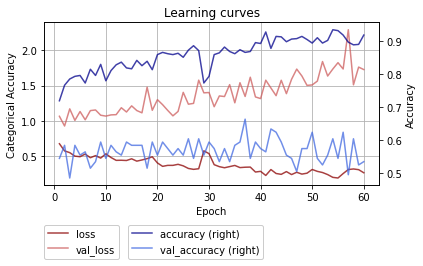

In [ ]:
#using ADAM and 60 epochs

#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn72.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 60
history722 = cnn72.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist722 = pd.DataFrame.from_dict(history722.history)
df_hist722["Epoch"] = np.arange(1, len(df_hist722) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist722.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

*CNN* 7.2.1 | GOING DEEPER (2 MORE LAYERS + Kernel size variation + filters variaton + dropout)

In [ ]:
input_shape = tuple(batch_x_train.shape)

# Architecture CNN7
# dense layer activation = softmax
# hidden layers activation = relu 

cnn721 = Sequential([
                   augmentation, 
                   layers.BatchNormalization(), 
                   # Feature extraction
                   layers.Conv2D(filters=64, kernel_size=(11,11),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=128, kernel_size=(5, 5),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dropout(0.5),
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer=regularizers.L2(1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn721.build(input_shape)

# Check network
cnn721.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (128, 128, 3)             0         
                                                                 
 batch_normalization_3 (Batc  (64, 128, 128, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_12 (Conv2D)          (64, 118, 118, 64)        23296     
                                                                 
 activation_12 (Activation)  (64, 118, 118, 64)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (64, 59, 59, 64)         0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (64, 55, 55, 128)        

Epoch 1/15


12/12 [==============================] - ETA: 0s - loss: 1.1864 - accuracy: 0.3535 - AUROC: 0.5397

12/12 [==============================] - 11s 464ms/step - loss: 1.1864 - accuracy: 0.3535 - AUROC: 0.5397 - val_loss: 1.1249 - val_accuracy: 0.4257 - val_AUROC: 0.5865
Epoch 2/15
12/12 [==============================] - 8s 655ms/step - loss: 1.1301 - accuracy: 0.3817 - AUROC: 0.5654 - val_loss: 1.1086 - val_accuracy: 0.3960 - val_AUROC: 0.6329
Epoch 3/15
12/12 [==============================] - 5s 410ms/step - loss: 1.1221 - accuracy: 0.3629 - AUROC: 0.5681 - val_loss: 1.1325 - val_accuracy: 0.3366 - val_AUROC: 0.5670
Epoch 4/15
12/12 [==============================] - 6s 450ms/step - loss: 1.1126 - accuracy: 0.4220 - AUROC: 0.6042 - val_loss: 1.1038 - val_accuracy: 0.3762 - val_AUROC: 0.6369
Epoch 5/15
12/12 [==============================] - 5s 409ms/step - loss: 1.1046 - accuracy: 0.4274 - AUROC: 0.6033 - val_loss: 1.1827 - val_accuracy: 0.3564 - val_AUROC: 0.5255
Epoch 6/15
12/12 [==============================] - 5s 412ms/step - loss: 1.0870 - accuracy: 0.4355 - AUROC: 0.6236 - va

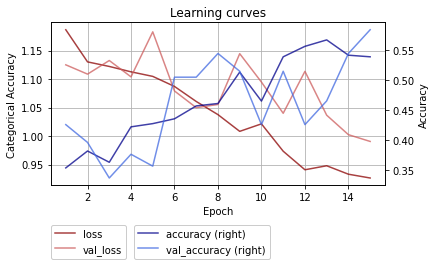

In [ ]:
#using ADAM and 15 epochs

#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn721.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 15
history721 = cnn721.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist721 = pd.DataFrame.from_dict(history721.history)
df_hist721["Epoch"] = np.arange(1, len(df_hist721) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist721.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

CNN 7.3 | GOING DEEPER (2 MORE LAYERS + Kernel size variation + NEW filters variaton)

In [ ]:
input_shape = tuple(batch_x_train.shape)

# Architecture CNN7
# dense layer activation = softmax
# hidden layers activation = relu 

cnn73 = Sequential([
                   augmentation, 
                   layers.BatchNormalization(), 
                   # Feature extraction
                   layers.Conv2D(filters=128, kernel_size=(11,11),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(5, 5),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer=regularizers.L2(1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn73.build(input_shape)

# Check network
cnn73.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (128, 128, 3)             0         
                                                                 
 batch_normalization_4 (Batc  (64, 128, 128, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_16 (Conv2D)          (64, 118, 118, 128)       46592     
                                                                 
 activation_16 (Activation)  (64, 118, 118, 128)       0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (64, 59, 59, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (64, 55, 55, 256)        

Epoch 1/30


12/12 [==============================] - ETA: 0s - loss: 1.3844 - accuracy: 0.3562 - AUROC: 0.5372

12/12 [==============================] - 22s 983ms/step - loss: 1.3844 - accuracy: 0.3562 - AUROC: 0.5372 - val_loss: 1.3046 - val_accuracy: 0.2574 - val_AUROC: 0.4200
Epoch 2/30
12/12 [==============================] - 6s 499ms/step - loss: 1.1490 - accuracy: 0.3562 - AUROC: 0.5638 - val_loss: 1.1999 - val_accuracy: 0.2574 - val_AUROC: 0.4487
Epoch 3/30
12/12 [==============================] - 7s 608ms/step - loss: 1.1510 - accuracy: 0.3804 - AUROC: 0.5643 - val_loss: 1.1961 - val_accuracy: 0.3366 - val_AUROC: 0.5752
Epoch 4/30
12/12 [==============================] - 6s 498ms/step - loss: 1.1327 - accuracy: 0.3629 - AUROC: 0.5892 - val_loss: 1.1731 - val_accuracy: 0.2970 - val_AUROC: 0.4575
Epoch 5/30
12/12 [==============================] - 6s 502ms/step - loss: 1.1260 - accuracy: 0.4140 - AUROC: 0.6023 - val_loss: 1.1455 - val_accuracy: 0.5347 - val_AUROC: 0.5830
Epoch 6/30
12/12 [==============================] - 7s 502ms/step - loss: 1.1161 - accuracy: 0.4247 - AUROC: 0.6056 - va

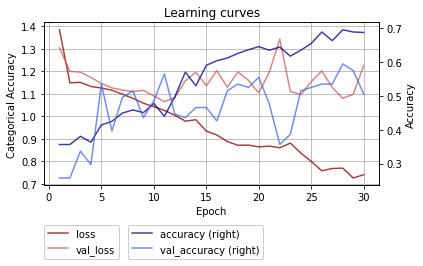

In [ ]:
#using ADAM and 30 epochs

#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn73.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 30
history73 = cnn73.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist73 = pd.DataFrame.from_dict(history73.history)
df_hist73["Epoch"] = np.arange(1, len(df_hist73) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist73.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

CNN 7.4 | Adding one more dense layer

In [ ]:
input_shape = tuple(batch_x_train.shape)

# Architecture CNN7
# dense layer activation = softmax
# hidden layers activation = relu 

cnn74 = Sequential([
                   augmentation, 
                   layers.BatchNormalization(), 
                   # Feature extraction
                   layers.Conv2D(filters=128, kernel_size=(11,11),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(5, 5),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=84, activation="relu",
                                kernel_regularizer=regularizers.L2(1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer=regularizers.L2(1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn74.build(input_shape)

# Check network
cnn74.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (128, 128, 3)             0         
                                                                 
 batch_normalization_5 (Batc  (64, 128, 128, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_20 (Conv2D)          (64, 118, 118, 128)       46592     
                                                                 
 activation_20 (Activation)  (64, 118, 118, 128)       0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (64, 59, 59, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (64, 55, 55, 256)        

Epoch 1/30


12/12 [==============================] - ETA: 0s - loss: 1.4012 - accuracy: 0.3239 - AUROC: 0.5153

12/12 [==============================] - 11s 532ms/step - loss: 1.4012 - accuracy: 0.3239 - AUROC: 0.5153 - val_loss: 1.6082 - val_accuracy: 0.2673 - val_AUROC: 0.4324
Epoch 2/30
12/12 [==============================] - 8s 611ms/step - loss: 1.1640 - accuracy: 0.3737 - AUROC: 0.5716 - val_loss: 1.4842 - val_accuracy: 0.3366 - val_AUROC: 0.4752
Epoch 3/30
12/12 [==============================] - 6s 500ms/step - loss: 1.1572 - accuracy: 0.3642 - AUROC: 0.5798 - val_loss: 1.1490 - val_accuracy: 0.4554 - val_AUROC: 0.6076
Epoch 4/30
12/12 [==============================] - 6s 507ms/step - loss: 1.1414 - accuracy: 0.3978 - AUROC: 0.5996 - val_loss: 1.2985 - val_accuracy: 0.2871 - val_AUROC: 0.4498
Epoch 5/30
12/12 [==============================] - 7s 607ms/step - loss: 1.1401 - accuracy: 0.3804 - AUROC: 0.5879 - val_loss: 1.2360 - val_accuracy: 0.2970 - val_AUROC: 0.4848
Epoch 6/30
12/12 [==============================] - 6s 499ms/step - loss: 1.1294 - accuracy: 0.3911 - AUROC: 0.6076 - va

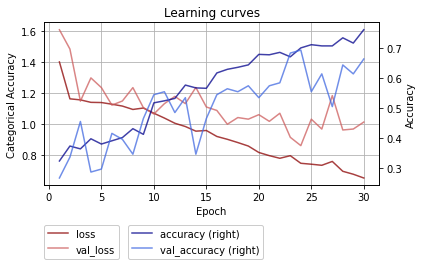

In [ ]:
#using ADAM and 30 epochs

#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn74.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 30
history74 = cnn74.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist74 = pd.DataFrame.from_dict(history74.history)
df_hist74["Epoch"] = np.arange(1, len(df_hist74) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist74.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

CNN 8 | GOING EVEN DEEPER

In [ ]:
input_shape = tuple(batch_x_train.shape)

# Architecture CNN7
# dense layer activation = softmax
# hidden layers activation = relu 

cnn8 = Sequential([
                   augmentation, 
                   layers.BatchNormalization(), 
                   # Feature extraction
                   layers.Conv2D(filters=128, kernel_size=(11,11),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(5, 5),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=3, activation="softmax",
                                kernel_regularizer=regularizers.L2(1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

# Builds the DAG (comment if input_shape was already provided to the first layer)
cnn8.build(input_shape)

# Check network
cnn8.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (128, 128, 3)             0         
                                                                 
 batch_normalization_6 (Batc  (64, 128, 128, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_24 (Conv2D)          (64, 118, 118, 128)       46592     
                                                                 
 activation_24 (Activation)  (64, 118, 118, 128)       0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (64, 59, 59, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (64, 55, 55, 256)        

Epoch 1/30


12/12 [==============================] - ETA: 0s - loss: 1.5833 - accuracy: 0.3522 - AUROC: 0.5317

12/12 [==============================] - 12s 643ms/step - loss: 1.5833 - accuracy: 0.3522 - AUROC: 0.5317 - val_loss: 1.2241 - val_accuracy: 0.3960 - val_AUROC: 0.6036
Epoch 2/30
12/12 [==============================] - 7s 525ms/step - loss: 1.1819 - accuracy: 0.3669 - AUROC: 0.5597 - val_loss: 1.2235 - val_accuracy: 0.3960 - val_AUROC: 0.6033
Epoch 3/30
12/12 [==============================] - 7s 540ms/step - loss: 1.1742 - accuracy: 0.3656 - AUROC: 0.5554 - val_loss: 1.2255 - val_accuracy: 0.3960 - val_AUROC: 0.6139
Epoch 4/30
12/12 [==============================] - 7s 550ms/step - loss: 1.1641 - accuracy: 0.3616 - AUROC: 0.5775 - val_loss: 1.1430 - val_accuracy: 0.3960 - val_AUROC: 0.6074
Epoch 5/30
12/12 [==============================] - 7s 518ms/step - loss: 1.1583 - accuracy: 0.4086 - AUROC: 0.5904 - val_loss: 1.1390 - val_accuracy: 0.3960 - val_AUROC: 0.6132
Epoch 6/30
12/12 [==============================] - 7s 580ms/step - loss: 1.1385 - accuracy: 0.3589 - AUROC: 0.5909 - va

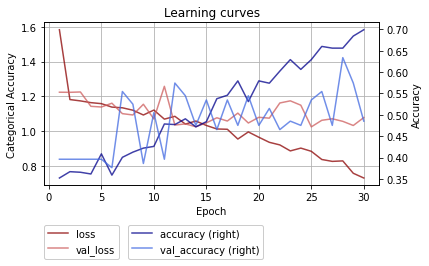

In [ ]:
#using ADAM and 30 epochs

#learning_rate
learning_rate = 0.001

# compiling model for trainning
# loss = categorical_crossentropy
# metrics -> categorical accuracy and AUC

cnn8.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
epochs = 30
history8 = cnn8.fit(ds_train, epochs=epochs, validation_data=ds_valid)


# ploting learning curve

df_hist8 = pd.DataFrame.from_dict(history8.history)
df_hist8["Epoch"] = np.arange(1, len(df_hist8) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"]  #  ["AUROC", "val_AUROC"] 
ax = df_hist8.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

***CNN VGG16***

In [ ]:
image_size=(224, 224)
crop_to_aspect_ratio = True
color_mode='rgb'
label_mode="categorical"
batch_size=64
shuffle=True
seed=0

In [ ]:
# Loading data/images

ds_trainvgg = image_dataset_from_directory(path + training_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

ds_validvgg = image_dataset_from_directory(path + validation_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

ds_testvgg = image_dataset_from_directory(path + testing_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)


# Check object properties
print("\nObject's type:\t", type(ds_trainvgg))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_trainvgg, tf.data.Dataset))
print("Classes:", ds_trainvgg.class_names)

Found 732 files belonging to 3 classes.
Found 101 files belonging to 3 classes.
Found 52 files belonging to 3 classes.

Object's type:	 <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['happy', 'normal', 'sad']


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_118 (Conv2D)         (None, 224, 224, 64)      1792      
                                                                 
 conv2d_119 (Conv2D)         (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_120 (Conv2D)         (None, 112, 112, 128)     73856     
                                                                 
 conv2d_121 (Conv2D)         (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                

 1/12 [=>............................] - ETA: 25s - loss: 1.0998 - accuracy: 0.4375 - AUROC: 0.6038

 2/12 [====>.........................] - ETA: 8s - loss: 10179.8779 - accuracy: 0.3828 - AUROC: 0.5230

 3/12 [======>.......................] - ETA: 7s - loss: 6787.2222 - accuracy: 0.3802 - AUROC: 0.5144 

 4/12 [=========>....................] - ETA: 6s - loss: 5090.6909 - accuracy: 0.3789 - AUROC: 0.5258

 5/12 [===========>..................] - ETA: 5s - loss: 4072.7805 - accuracy: 0.3656 - AUROC: 0.5172

 6/12 [==============>...............] - ETA: 4s - loss: 3394.1663 - accuracy: 0.3724 - AUROC: 0.5226

 7/12 [================>.............] - ETA: 4s - loss: 2909.4392 - accuracy: 0.3661 - AUROC: 0.5312

 8/12 [===================>..........] - ETA: 3s - loss: 2545.9028 - accuracy: 0.3574 - AUROC: 0.5236

 9/12 [=====================>........] - ETA: 2s - loss: 2263.1470 - accuracy: 0.3524 - AUROC: 0.5243

10/12 [========================>.....] - ETA: 1s - loss: 2036.9421 - accuracy: 0.3516 - AUROC: 0.5243

11/12 [==========================>...] - ETA: 0s - loss: 1851.8663 - accuracy: 0.3395 - AUROC: 0.5174

12/12 [==============================] - 11s 831ms/step - loss: 1781.0720 - accuracy: 0.3333 - AUROC: 0.5157 - val_loss: 1.0968 - val_accuracy: 0.3960 - val_AUROC: 0.5354
Epoch 2/20


 1/12 [=>............................] - ETA: 13s - loss: 1.1004 - accuracy: 0.3906 - AUROC: 0.4642

 2/12 [====>.........................] - ETA: 8s - loss: 1.0993 - accuracy: 0.3672 - AUROC: 0.5076 

 3/12 [======>.......................] - ETA: 7s - loss: 1.0951 - accuracy: 0.3750 - AUROC: 0.5330

 4/12 [=========>....................] - ETA: 6s - loss: 1.1490 - accuracy: 0.4023 - AUROC: 0.5736

 5/12 [===========>..................] - ETA: 5s - loss: 1.1391 - accuracy: 0.3812 - AUROC: 0.5611

 6/12 [==============>...............] - ETA: 4s - loss: 1.1322 - accuracy: 0.3724 - AUROC: 0.5532

 7/12 [================>.............] - ETA: 3s - loss: 1.1362 - accuracy: 0.3549 - AUROC: 0.5223

 8/12 [===================>..........] - ETA: 3s - loss: 1.1312 - accuracy: 0.3555 - AUROC: 0.5220

 9/12 [=====================>........] - ETA: 2s - loss: 1.1269 - accuracy: 0.3628 - AUROC: 0.5316

10/12 [========================>.....] - ETA: 1s - loss: 1.1181 - accuracy: 0.3672 - AUROC: 0.5491

11/12 [==========================>...] - ETA: 0s - loss: 1.1178 - accuracy: 0.3594 - AUROC: 0.5404

12/12 [==============================] - 10s 810ms/step - loss: 1.1171 - accuracy: 0.3566 - AUROC: 0.5385 - val_loss: 1.0966 - val_accuracy: 0.3960 - val_AUROC: 0.5343
Epoch 3/20


 1/12 [=>............................] - ETA: 17s - loss: 1.1053 - accuracy: 0.2344 - AUROC: 0.3859

 2/12 [====>.........................] - ETA: 8s - loss: 1.1021 - accuracy: 0.3125 - AUROC: 0.4321 

 3/12 [======>.......................] - ETA: 7s - loss: 1.1035 - accuracy: 0.3021 - AUROC: 0.4375

 4/12 [=========>....................] - ETA: 6s - loss: 1.1013 - accuracy: 0.3164 - AUROC: 0.4734

 5/12 [===========>..................] - ETA: 5s - loss: 1.1045 - accuracy: 0.3187 - AUROC: 0.4811

 6/12 [==============>...............] - ETA: 4s - loss: 1.1022 - accuracy: 0.3385 - AUROC: 0.4978

 7/12 [================>.............] - ETA: 4s - loss: 1.1018 - accuracy: 0.3415 - AUROC: 0.5004

 8/12 [===================>..........] - ETA: 3s - loss: 1.1046 - accuracy: 0.3379 - AUROC: 0.4973

 9/12 [=====================>........] - ETA: 2s - loss: 1.1048 - accuracy: 0.3351 - AUROC: 0.4956

10/12 [========================>.....] - ETA: 1s - loss: 1.1037 - accuracy: 0.3406 - AUROC: 0.5014

11/12 [==========================>...] - ETA: 0s - loss: 1.1028 - accuracy: 0.3423 - AUROC: 0.5043

12/12 [==============================] - 10s 806ms/step - loss: 1.1027 - accuracy: 0.3402 - AUROC: 0.5031 - val_loss: 1.0941 - val_accuracy: 0.3366 - val_AUROC: 0.5347
Epoch 4/20


 1/12 [=>............................] - ETA: 14s - loss: 1.0904 - accuracy: 0.4844 - AUROC: 0.6172

 2/12 [====>.........................] - ETA: 8s - loss: 1.0910 - accuracy: 0.4531 - AUROC: 0.5938 

 3/12 [======>.......................] - ETA: 7s - loss: 1.0915 - accuracy: 0.4271 - AUROC: 0.5715

 4/12 [=========>....................] - ETA: 6s - loss: 1.0926 - accuracy: 0.4062 - AUROC: 0.5545

 5/12 [===========>..................] - ETA: 5s - loss: 1.0953 - accuracy: 0.3938 - AUROC: 0.5346

 6/12 [==============>...............] - ETA: 4s - loss: 1.0963 - accuracy: 0.3802 - AUROC: 0.5258

 7/12 [================>.............] - ETA: 3s - loss: 1.0968 - accuracy: 0.3683 - AUROC: 0.5207

 8/12 [===================>..........] - ETA: 3s - loss: 1.0970 - accuracy: 0.3633 - AUROC: 0.5192

 9/12 [=====================>........] - ETA: 2s - loss: 1.0963 - accuracy: 0.3628 - AUROC: 0.5229

10/12 [========================>.....] - ETA: 1s - loss: 1.0969 - accuracy: 0.3562 - AUROC: 0.5189

11/12 [==========================>...] - ETA: 0s - loss: 1.0966 - accuracy: 0.3565 - AUROC: 0.5207

12/12 [==============================] - 10s 803ms/step - loss: 1.0967 - accuracy: 0.3525 - AUROC: 0.5202 - val_loss: 1.0928 - val_accuracy: 0.3366 - val_AUROC: 0.5347
Epoch 5/20


 1/12 [=>............................] - ETA: 13s - loss: 1.0900 - accuracy: 0.3594 - AUROC: 0.5547

 2/12 [====>.........................] - ETA: 8s - loss: 1.0969 - accuracy: 0.3516 - AUROC: 0.5234 

 3/12 [======>.......................] - ETA: 7s - loss: 1.0924 - accuracy: 0.3490 - AUROC: 0.5395

 4/12 [=========>....................] - ETA: 6s - loss: 1.0926 - accuracy: 0.3555 - AUROC: 0.5386

 5/12 [===========>..................] - ETA: 5s - loss: 1.0937 - accuracy: 0.3594 - AUROC: 0.5316

 6/12 [==============>...............] - ETA: 4s - loss: 1.0957 - accuracy: 0.3490 - AUROC: 0.5172

 7/12 [================>.............] - ETA: 3s - loss: 1.0957 - accuracy: 0.3482 - AUROC: 0.5182

 8/12 [===================>..........] - ETA: 3s - loss: 1.0952 - accuracy: 0.3574 - AUROC: 0.5244

 9/12 [=====================>........] - ETA: 2s - loss: 1.0942 - accuracy: 0.3681 - AUROC: 0.5354

10/12 [========================>.....] - ETA: 1s - loss: 1.0940 - accuracy: 0.3547 - AUROC: 0.5264

11/12 [==========================>...] - ETA: 0s - loss: 1.0944 - accuracy: 0.3537 - AUROC: 0.5250

12/12 [==============================] - 10s 801ms/step - loss: 1.0952 - accuracy: 0.3511 - AUROC: 0.5208 - val_loss: 1.0893 - val_accuracy: 0.3960 - val_AUROC: 0.5644
Epoch 6/20


 1/12 [=>............................] - ETA: 13s - loss: 1.0872 - accuracy: 0.3125 - AUROC: 0.5391

 2/12 [====>.........................] - ETA: 8s - loss: 1.0907 - accuracy: 0.3906 - AUROC: 0.5439 

 3/12 [======>.......................] - ETA: 7s - loss: 1.0894 - accuracy: 0.3646 - AUROC: 0.5391

 4/12 [=========>....................] - ETA: 6s - loss: 1.0927 - accuracy: 0.3516 - AUROC: 0.5269

 5/12 [===========>..................] - ETA: 5s - loss: 1.0928 - accuracy: 0.3500 - AUROC: 0.5278

 6/12 [==============>...............] - ETA: 4s - loss: 1.0958 - accuracy: 0.3438 - AUROC: 0.5171

 7/12 [================>.............] - ETA: 3s - loss: 1.0946 - accuracy: 0.3571 - AUROC: 0.5263

 8/12 [===================>..........] - ETA: 3s - loss: 1.0927 - accuracy: 0.3711 - AUROC: 0.5383

 9/12 [=====================>........] - ETA: 2s - loss: 1.0958 - accuracy: 0.3576 - AUROC: 0.5244

10/12 [========================>.....] - ETA: 1s - loss: 1.0946 - accuracy: 0.3609 - AUROC: 0.5299

11/12 [==========================>...] - ETA: 0s - loss: 1.0939 - accuracy: 0.3608 - AUROC: 0.5323

12/12 [==============================] - 10s 803ms/step - loss: 1.0948 - accuracy: 0.3566 - AUROC: 0.5284 - val_loss: 1.0894 - val_accuracy: 0.3960 - val_AUROC: 0.5644
Epoch 6: early stopping


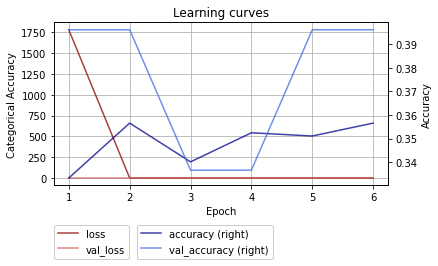

In [ ]:
modelvgg16 = Sequential()
modelvgg16.add(layers.Conv2D(input_shape=(224,224,3), filters=64,kernel_size=(3,3),padding="same", activation="relu"))
modelvgg16.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
modelvgg16.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
modelvgg16.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
modelvgg16.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
modelvgg16.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
modelvgg16.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
modelvgg16.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
modelvgg16.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
modelvgg16.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
modelvgg16.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
modelvgg16.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
modelvgg16.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
modelvgg16.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
modelvgg16.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
modelvgg16.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
modelvgg16.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
modelvgg16.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
modelvgg16.add(layers.Flatten())
modelvgg16.add(layers.Dense(units=4096,activation="relu"))
modelvgg16.add(layers.Dense(units=4096,activation="relu"))
modelvgg16.add(layers.Dense(units=3, activation="softmax"))

modelvgg16.summary()

# Compile model
modelvgg16.compile(loss='categorical_crossentropy', 
              optimizer=tf.optimizers.Adam(learning_rate=0.001), 
              metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')
historyvgg = modelvgg16.fit(ds_trainvgg, epochs=20, validation_data=ds_validvgg, callbacks=[checkpoint,early])

#ploting learning curve
df_histvgg = pd.DataFrame.from_dict(historyvgg.history)
df_histvgg["Epoch"] = np.arange(1, len(df_histvgg) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"] #["AUROC", "val_AUROC"] 
ax = df_histvgg.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

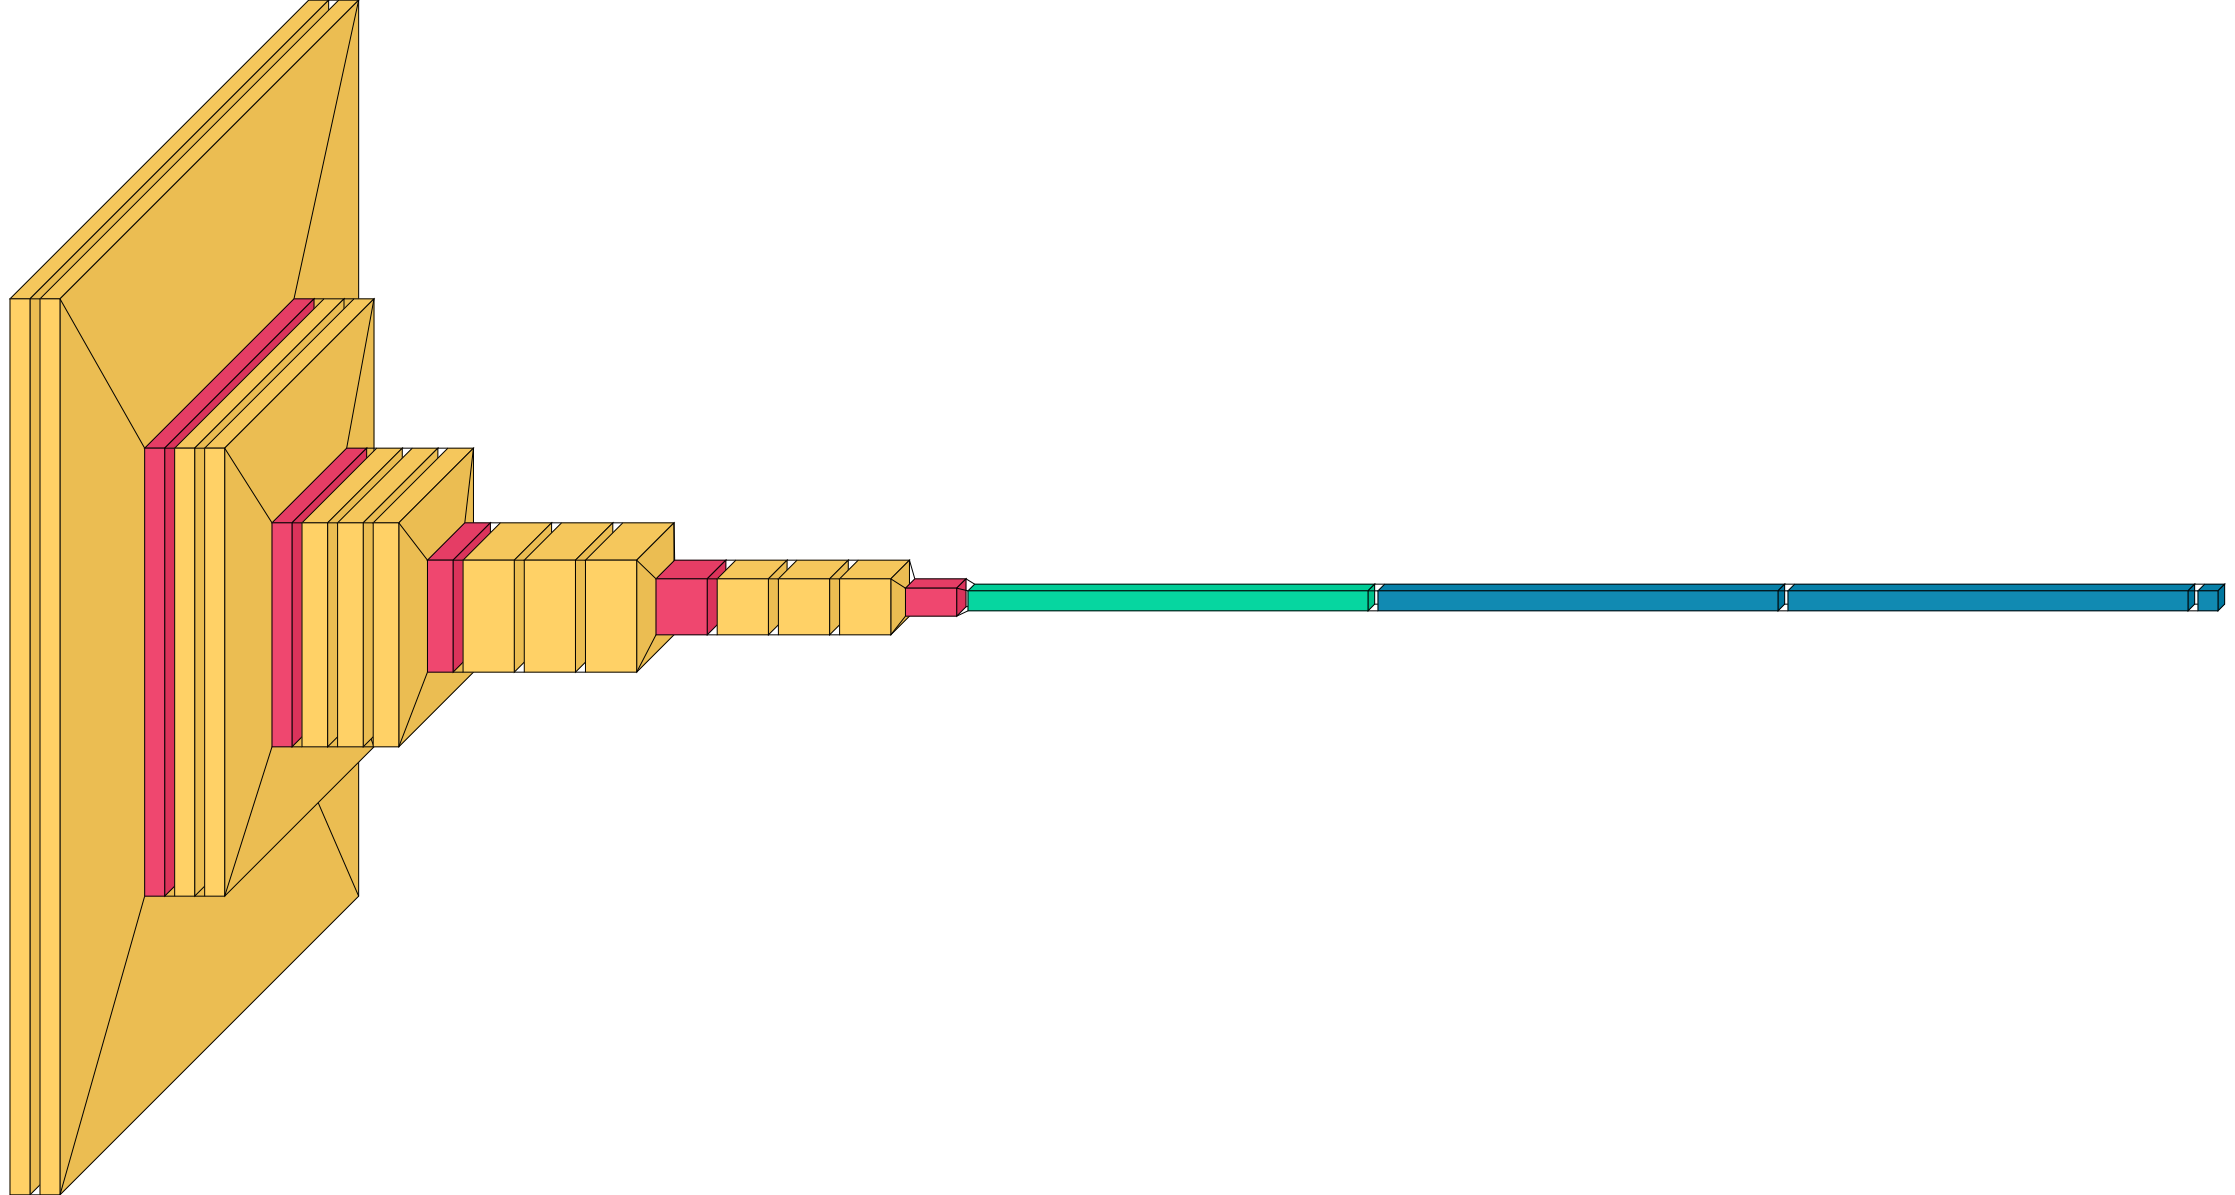

In [ ]:
#visualize the model
visualkeras.layered_view(modelvgg16)

***CNN AlexNet***

This Convolutional Neural Network architecture contains eight layers with weights, where the first five layers are convolutional, and the remaining three are fully-connected layers.

In [ ]:
image_size=(227, 227)
crop_to_aspect_ratio = True
color_mode='rgb'
label_mode="categorical"
batch_size=64
shuffle=True
seed=0

In [ ]:
# Loading data/images

ds_train1 = image_dataset_from_directory(path + training_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

ds_valid1 = image_dataset_from_directory(path + validation_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

ds_test1 = image_dataset_from_directory(path + testing_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)


# Check object properties
print("\nObject's type:\t", type(ds_train1))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_train1, tf.data.Dataset))
print("Classes:", ds_train1.class_names)

Found 732 files belonging to 3 classes.
Found 101 files belonging to 3 classes.
Found 52 files belonging to 3 classes.

Object's type:	 <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['happy', 'normal', 'sad']


In [ ]:
#train data

iter_train1 = iter(ds_train1)
batch_x_train1, batch_y_train1 = iter_train1.next()
print(batch_x_train1.shape, batch_y_train1.shape)
print("\nSample of y_train:", batch_y_train1[0:5])
print("Sample average of y_train:", tf.reduce_mean(batch_y_train1))

(64, 227, 227, 3) (64, 3)

Sample of y_train: tf.Tensor(
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]], shape=(5, 3), dtype=float32)
Sample average of y_train: tf.Tensor(0.33333334, shape=(), dtype=float32)


In [ ]:
#test data

iter_test1 = iter(ds_test1)
batch_x_test1, batch_y_test1 = iter_test1.next()
print(batch_x_test1.shape, batch_y_test1.shape)
print("\nSample of y_train:", batch_y_test1[0:5])
print("Sample average of y_train:", tf.reduce_mean(batch_y_test1))

(52, 227, 227, 3) (52, 3)

Sample of y_train: tf.Tensor(
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]], shape=(5, 3), dtype=float32)
Sample average of y_train: tf.Tensor(0.33333334, shape=(), dtype=float32)


In [ ]:
batch_y_test1

<tf.Tensor: shape=(52, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
      

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 384)       1

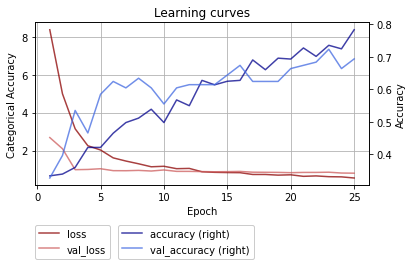

In [ ]:
modelAlexN = Sequential()
modelAlexN.add(layers.Conv2D(filters=96, kernel_size=(11, 11), 
                        strides=(4, 4), activation="relu", input_shape=(227,227,3)))
#modelAlexN.add(layers.BatchNormalization()),
modelAlexN.add(layers.MaxPool2D(pool_size=(3, 3), strides= (2, 2)))
modelAlexN.add(layers.Conv2D(filters=256, kernel_size=(5, 5), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
#modelAlexN.add(layers.BatchNormalization()),
modelAlexN.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
modelAlexN.add(layers.Conv2D(filters=384, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
#modelAlexN.add(layers.BatchNormalization()),
modelAlexN.add(layers.Conv2D(filters=384, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
#modelAlexN.add(layers.BatchNormalization()),
modelAlexN.add(layers.Conv2D(filters=256, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
#modelAlexN.add(layers.BatchNormalization()),
modelAlexN.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
modelAlexN.add(layers.Flatten())
modelAlexN.add(layers.Dense(4096, activation="relu"))
modelAlexN.add(layers.Dropout(0.6))
modelAlexN.add(layers.Dense(4096, activation="relu"))
modelAlexN.add(layers.Dropout(0.6))
modelAlexN.add(layers.Dense(3, activation="softmax"))

modelAlexN.summary()


# Compile model
modelAlexN.compile(loss='categorical_crossentropy', 
              optimizer=tf.optimizers.Adam(learning_rate=0.00001), 
              metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
historyAlexN = modelAlexN.fit(ds_train1, epochs=25, validation_data=ds_valid1)

# ploting learning curve
df_modelAlexN = pd.DataFrame.from_dict(historyAlexN.history)
df_modelAlexN["Epoch"] = np.arange(1, len(df_modelAlexN) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"] #["AUROC", "val_AUROC"] 
ax = df_modelAlexN.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

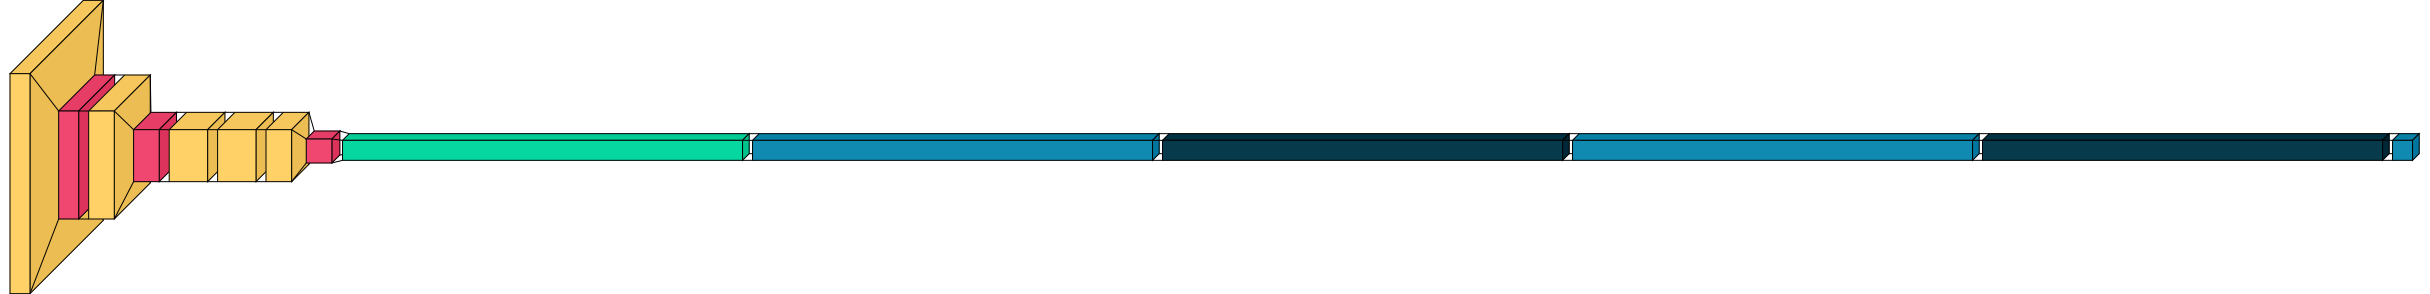

In [ ]:
#visualize the model
visualkeras.layered_view(modelAlexN)

In [ ]:
modelAlexN1 = Sequential()
modelAlexN1.add(layers.RandomRotation(0.1, seed=seed)),
modelAlexN1.add(layers.RandomZoom(0.1, seed=seed)),
modelAlexN1.add(layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))),
modelAlexN1.add(layers.Conv2D(filters=96, kernel_size=(11, 11), 
                        strides=(4, 4), activation="relu", input_shape=(227,227,3)))
modelAlexN1.add(layers.MaxPool2D(pool_size=(3, 3), strides= (2, 2)))
modelAlexN1.add(layers.Conv2D(filters=256, kernel_size=(11, 11), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
modelAlexN1.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
modelAlexN1.add(layers.Conv2D(filters=384, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
modelAlexN1.add(layers.Conv2D(filters=384, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
modelAlexN1.add(layers.Conv2D(filters=256, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
modelAlexN1.add(layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
modelAlexN1.add(layers.Flatten())
modelAlexN1.add(layers.Dense(4096, activation="relu"))
modelAlexN1.add(layers.Dropout(0.6))
modelAlexN1.add(layers.Dense(4096, activation="relu"))
modelAlexN1.add(layers.Dropout(0.6))
modelAlexN1.add(layers.Dense(3, activation="softmax"))


Epoch 1/80


12/12 [==============================] - 12s 508ms/step - loss: 11.0338 - accuracy: 0.3388 - AUROC: 0.5029 - val_loss: 1.1864 - val_accuracy: 0.4356 - val_AUROC: 0.6049
Epoch 2/80
12/12 [==============================] - 5s 400ms/step - loss: 5.3950 - accuracy: 0.3525 - AUROC: 0.5207 - val_loss: 1.1317 - val_accuracy: 0.4653 - val_AUROC: 0.6513
Epoch 3/80
12/12 [==============================] - 5s 398ms/step - loss: 3.4031 - accuracy: 0.3648 - AUROC: 0.5272 - val_loss: 1.2463 - val_accuracy: 0.3762 - val_AUROC: 0.6115
Epoch 4/80
12/12 [==============================] - 6s 445ms/step - loss: 2.6078 - accuracy: 0.3279 - AUROC: 0.5080 - val_loss: 1.0846 - val_accuracy: 0.5248 - val_AUROC: 0.6820
Epoch 5/80
12/12 [==============================] - 5s 399ms/step - loss: 1.8773 - accuracy: 0.4139 - AUROC: 0.5751 - val_loss: 1.0244 - val_accuracy: 0.5842 - val_AUROC: 0.7248
Epoch 6/80
12/12 [==============================] - 5s 391ms/step - loss: 1.7237 - accuracy: 0.3962 - AUROC: 0.5813 - v

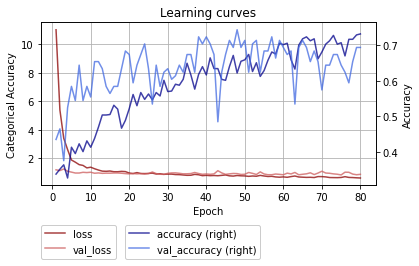

In [ ]:
# Compile model
modelAlexN1.compile(loss='categorical_crossentropy', 
              optimizer=tf.optimizers.Adam(learning_rate=0.00001), 
              metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                      metrics.AUC(name='AUROC')])


# Model training
historyAlexN1 = modelAlexN1.fit(ds_train1, epochs=80, validation_data=ds_valid1)

# ploting learning curve
df_modelAlexN1 = pd.DataFrame.from_dict(historyAlexN1.history)
df_modelAlexN1["Epoch"] = np.arange(1, len(df_modelAlexN1) + 1, 1)

# Plot learning curves
secondary_y = ["accuracy", "val_accuracy"] #["AUROC", "val_AUROC"] 
ax = df_modelAlexN1.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(6, 3), grid=True, legend=True,
                   ylabel="Categorical Accuracy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

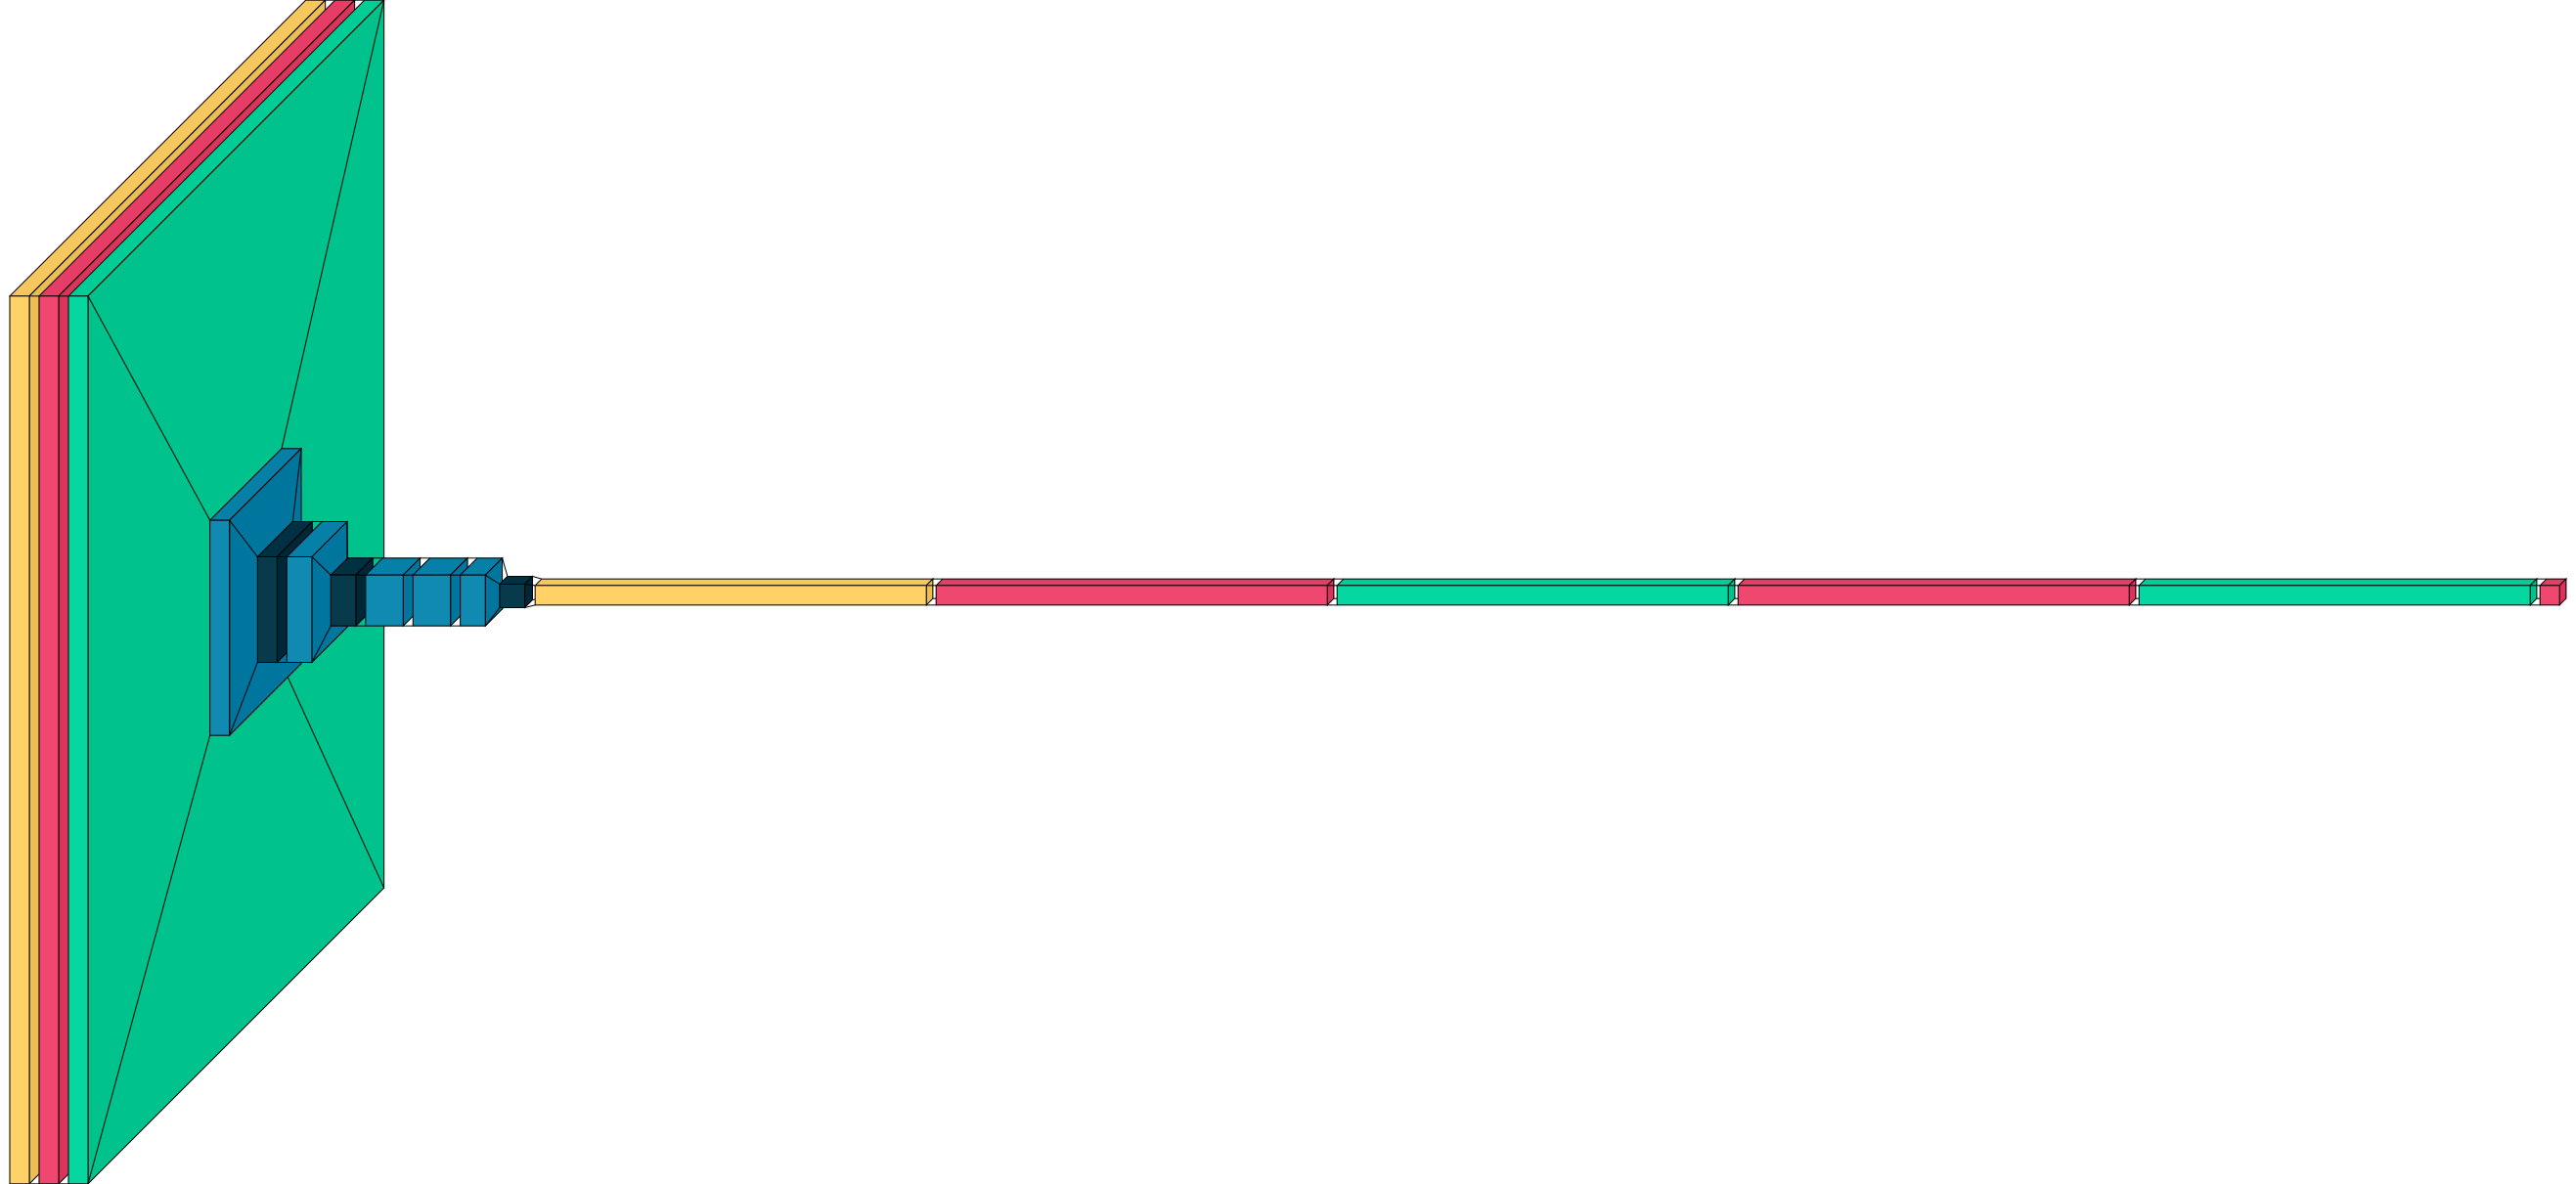

In [ ]:
#visualize the model
visualkeras.layered_view(modelAlexN1)

USING THE BEST MODEL ON TEST DATA

In [ ]:
# model AlexNet 

modelAlexN_test = modelAlexN.predict(ds_test1)

1/1 [==============================] - 1s 569ms/step


In [ ]:
modelAlexN_test

array([[0.15039302, 0.19564773, 0.6539593 ],
       [0.05642762, 0.27343956, 0.67013276],
       [0.05112237, 0.18213452, 0.76674306],
       [0.05378921, 0.17246504, 0.7737458 ],
       [0.35772008, 0.5933041 , 0.04897588],
       [0.4339787 , 0.53815913, 0.02786213],
       [0.03614851, 0.15243125, 0.8114202 ],
       [0.4885033 , 0.34744233, 0.16405435],
       [0.36128905, 0.21772698, 0.42098397],
       [0.4918014 , 0.4985501 , 0.00964849],
       [0.49653932, 0.3308064 , 0.1726542 ],
       [0.09576585, 0.18529129, 0.7189429 ],
       [0.26580492, 0.6295469 , 0.10464821],
       [0.8659956 , 0.11264145, 0.02136298],
       [0.22507507, 0.48448384, 0.2904411 ],
       [0.29228464, 0.64287376, 0.06484158],
       [0.35718527, 0.35958263, 0.28323206],
       [0.04805426, 0.21763246, 0.73431325],
       [0.40743804, 0.3215456 , 0.2710164 ],
       [0.06087485, 0.1753009 , 0.7638242 ],
       [0.5213971 , 0.46559292, 0.01300998],
       [0.6941171 , 0.29116076, 0.01472208],
       [0.

In [ ]:
batch_y_test1

<tf.Tensor: shape=(52, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
      

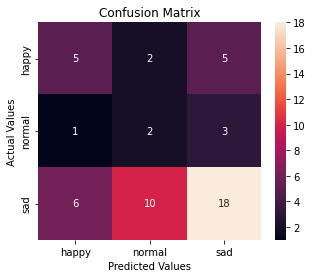

In [ ]:
y_pred=np.argmax(modelAlexN_test, axis=1)
y_test=np.argmax(batch_y_test1, axis=1)
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['happy','normal','sad'], 
                     columns = ['happy','normal','sad'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
# model AlexNet 

modelAlexN1_test = modelAlexN1.predict(ds_test1)

1/1 [==============================] - 0s 81ms/step


In [ ]:
modelAlexN1_test

array([[4.39279974e-01, 5.50364852e-01, 1.03552053e-02],
       [8.70616019e-01, 1.17582552e-01, 1.18014384e-02],
       [2.11507112e-01, 7.05569983e-02, 7.17935860e-01],
       [9.78222728e-01, 1.88620929e-02, 2.91518122e-03],
       [2.51834560e-02, 9.51457694e-02, 8.79670739e-01],
       [7.38306224e-01, 1.85455099e-01, 7.62386471e-02],
       [3.52304452e-03, 1.85060734e-03, 9.94626343e-01],
       [1.02500059e-02, 7.76725188e-02, 9.12077427e-01],
       [1.45429224e-01, 2.68466413e-01, 5.86104333e-01],
       [1.37527874e-02, 7.39989579e-02, 9.12248254e-01],
       [6.56009793e-01, 3.42489243e-01, 1.50095194e-03],
       [9.19378877e-01, 8.05537328e-02, 6.73917966e-05],
       [4.21898626e-02, 1.44268125e-01, 8.13542008e-01],
       [5.96881449e-01, 3.87627572e-01, 1.54909641e-02],
       [5.50070684e-03, 4.22404744e-02, 9.52258825e-01],
       [1.18397951e-01, 9.02784839e-02, 7.91323602e-01],
       [3.10630172e-01, 4.45170671e-01, 2.44199142e-01],
       [5.01539171e-01, 4.67710

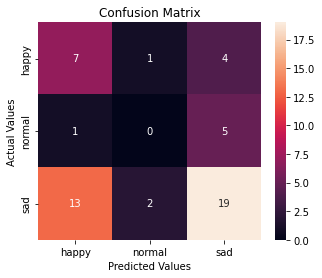

In [ ]:
y_pred=np.argmax(modelAlexN1_test, axis=1)
y_test=np.argmax(batch_y_test1, axis=1)
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['happy','normal','sad'], 
                     columns = ['happy','normal','sad'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()